In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment3/'
FOLDERNAME = 'comp451/Project/visual-transformer'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
import os
sys.path.append('/content/drive/MyDrive/{}'.format(FOLDERNAME))

os.chdir('/content/drive/MyDrive/comp451/Project/visual-transformer')


Mounted at /content/drive


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
from models.vt_resnet import VTResNet
from models.resnet import BasicBlock

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
import torchvision
from torch.utils.data import DataLoader, Subset

In [6]:
transform = torchvision.transforms.Compose([
     torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [7]:
data_train = torchvision.datasets.CIFAR10('/data', train=True, download=True, transform=transform)
data_valid = torchvision.datasets.CIFAR10('/data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
import torch.nn.functional as F

In [9]:
import pickle

def store_params(content, name):
    f = open("logs/" + name + ".pkl","wb")
    pickle.dump(content, f)
    f.close()

def load_params(name):
    fl = open("logs/" + name + ".pkl", "rb")
    loaded = pickle.load(fl)
    return loaded


In [10]:
def train(model, optimizer, data_loader):
   
    total_samples = len(data_loader.dataset)
    model.train()
    model.to(device)

    loss_history = []

    for i, (data, target) in enumerate(data_loader):
        
        data = data.to(device)
        target = target.to(device)

        optimizer.zero_grad()
        output = F.log_softmax(model(data), dim=1)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        loss_history.append(loss.item())
        if i % 100 == 0:
            print('[' +  '{:5}'.format(i * len(data)) + '/' + '{:5}'.format(total_samples) +
                  ' (' + '{:3.0f}'.format(100 * i / len(data_loader)) + '%)]  Loss: ' +
                  '{:6.4f}'.format(loss.item()))
    return loss_history

In [11]:
def evaluate(model, data_loader, mode):
    
    model.eval()
    
    total_samples = len(data_loader.dataset)
    correct_samples = 0
    total_loss = 0
    loss_history = []

    with torch.no_grad():
        for data, target in data_loader:
            data = data.to(device)
            target = target.to(device)
            output = F.log_softmax(model(data), dim=1)
            loss = F.nll_loss(output, target, reduction='sum')
            _, pred = torch.max(output, dim=1)
            
            total_loss += loss.item()
            correct_samples += pred.eq(target).sum()

    avg_loss = total_loss / total_samples
    loss_history.append(avg_loss)
    print('\nAverage '+ mode + ' loss: ' + '{:.4f}'.format(avg_loss) +
          '  Accuracy:' + '{:5}'.format(correct_samples) + '/' +
          '{:5}'.format(total_samples) + ' (' +
          '{:4.2f}'.format(100.0 * correct_samples / total_samples) + '%)\n')
    accuracy = 100.0 * correct_samples / total_samples
    return accuracy, loss_history

In [12]:
N = 256

train_loader = DataLoader(data_train, batch_size=N, shuffle=True)
valid_loader = DataLoader(data_valid, batch_size=N, shuffle=False)

L = 8
C = 1
H = 32
W = 32
D = 128

model = VTResNet(
    resnet_block=BasicBlock,
    layers=[2,2,2,2],
    tokens=L,
    token_channels=D,
    input_dim=H,
    layer_planes=[16, 32, 64, 128],
    num_classes=10
)
lr = 0.01

In [13]:
import matplotlib.pyplot as plt

In [14]:
def train_attempt(model, optimizer, train_data, valid_data, epochs, lr, lr_decay, decay_every, weight_decay, optim):

    EPOCHS = 10
    all_history = []
    valid_history = []
    final_train_acc = 0
    final_valid_acc = 0
    for i in range(epochs):

        if i % decay_every:
            lr *= lr_decay
            optimizer = optim(model.parameters(), lr=lr, weight_decay=weight_decay)

        history = train(model, optimizer, train_data)
        all_history = all_history + history
        plt.plot(history)
        plt.show()
        print("Epoch " + str(i) + " done.")
        final_valid_acc, valid_hist = evaluate(model, valid_data, 'test')
        final_train_acc, train_hist = evaluate(model, train_data, 'train')
        valid_history = valid_history + valid_hist

    plt.plot(all_history)

    return final_valid_acc, final_train_acc, all_history

In [15]:
import random
def param_search():

    valid_loader = DataLoader(Subset(data_valid, list(range(5000))), batch_size=128, shuffle=False)

    l = 0.001
    r = 0.007
    lr_trials = 15
    Ls = [8]
    Ns = [128]
    Ds = [512]
    optims = [torch.optim.Adam]
    weight_decay = 4e-5
    lr_decay = 0.5
    decay_every = 4
    epochs = 10
    best = {}
    best['valid_acc'] = 0

    all_count = 0
    best_count = 0


    for N in Ns:
        for D in Ds:
            for L in Ls:
                for optim in optims:
                    for _ in range(lr_trials):
                        
                        lr = random.uniform(l, r)
                        
                        train_loader = DataLoader(data_train, batch_size=N, shuffle=False)

                        model = VTResNet(
                            resnet_block=BasicBlock,
                            layers=[2,2,2,2],
                            tokens=L,
                            token_channels=D,
                            input_dim=32,
                            layer_planes=[16, 32, 64, 128],
                            num_classes=10
                        )
                        
                       
                        optimizer = optim(model.parameters(), lr=lr, weight_decay=weight_decay)

                        valid_acc, train_acc, all_hist = train_attempt(
                            model, 
                            optimizer, 
                            train_loader, 
                            valid_loader, 
                            epochs,
                            lr,
                            lr_decay,
                            decay_every,
                            weight_decay,
                            optim
                            )

                        if valid_acc > best['valid_acc']:
                            best['valid_acc'] = valid_acc
                            best['train_acc'] = train_acc
                            best['lr'] = lr
                            best['L'] = L
                            best['N'] = N
                            best['D'] = D
                            best['optim'] = optim

                            store_params(best, "best_params_2_" + str(best_count))
                            best_count += 1


                        store_params(best, "params_2_" + str(all_count))
                        all_count += 1

                        print('Best So Far:')
                        print(best)

    return best

[    0/50000 (  0%)]  Loss: 3.1132
[12800/50000 ( 26%)]  Loss: 2.3566
[25600/50000 ( 51%)]  Loss: 2.4345
[38400/50000 ( 77%)]  Loss: 1.8314


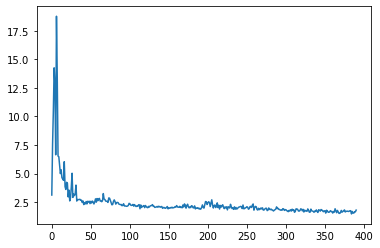

Epoch 0 done.

Average test loss: 1.6351  Accuracy: 1912/ 5000 (38.24%)


Average train loss: 1.6557  Accuracy:18677/50000 (37.35%)

[    0/50000 (  0%)]  Loss: 1.7099
[12800/50000 ( 26%)]  Loss: 1.5083
[25600/50000 ( 51%)]  Loss: 1.5944
[38400/50000 ( 77%)]  Loss: 1.5870


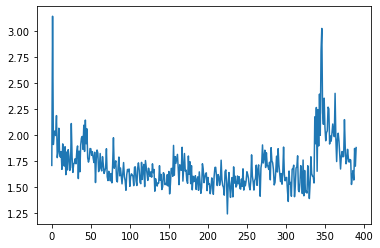

Epoch 1 done.

Average test loss: 1.6900  Accuracy: 1918/ 5000 (38.36%)


Average train loss: 1.7093  Accuracy:18489/50000 (36.98%)

[    0/50000 (  0%)]  Loss: 1.7001
[12800/50000 ( 26%)]  Loss: 1.4732
[25600/50000 ( 51%)]  Loss: 1.5529
[38400/50000 ( 77%)]  Loss: 1.3827


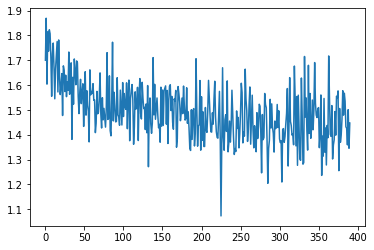

Epoch 2 done.

Average test loss: 1.4464  Accuracy: 2389/ 5000 (47.78%)


Average train loss: 1.4292  Accuracy:23979/50000 (47.96%)

[    0/50000 (  0%)]  Loss: 1.3399
[12800/50000 ( 26%)]  Loss: 1.2842
[25600/50000 ( 51%)]  Loss: 1.3547
[38400/50000 ( 77%)]  Loss: 1.2357


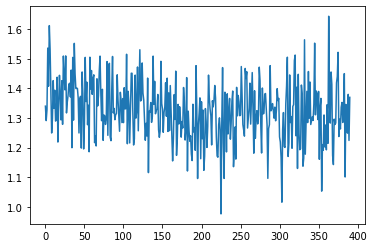

Epoch 3 done.

Average test loss: 1.3005  Accuracy: 2631/ 5000 (52.62%)


Average train loss: 1.2862  Accuracy:26321/50000 (52.64%)

[    0/50000 (  0%)]  Loss: 1.1641
[12800/50000 ( 26%)]  Loss: 1.2497
[25600/50000 ( 51%)]  Loss: 1.3423
[38400/50000 ( 77%)]  Loss: 1.1948


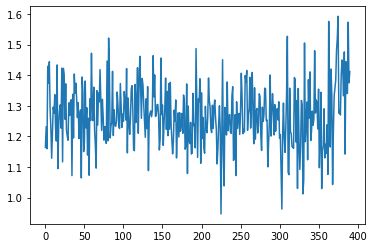

Epoch 4 done.

Average test loss: 1.4028  Accuracy: 2435/ 5000 (48.70%)


Average train loss: 1.3994  Accuracy:24314/50000 (48.63%)

[    0/50000 (  0%)]  Loss: 1.3054
[12800/50000 ( 26%)]  Loss: 1.2527
[25600/50000 ( 51%)]  Loss: 1.3037
[38400/50000 ( 77%)]  Loss: 1.1762


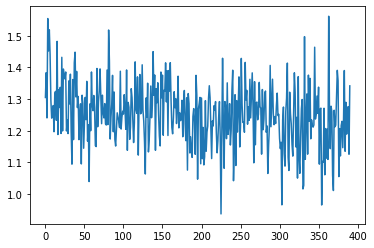

Epoch 5 done.

Average test loss: 1.2456  Accuracy: 2712/ 5000 (54.24%)


Average train loss: 1.2173  Accuracy:27726/50000 (55.45%)

[    0/50000 (  0%)]  Loss: 1.1303
[12800/50000 ( 26%)]  Loss: 1.1910
[25600/50000 ( 51%)]  Loss: 1.2232
[38400/50000 ( 77%)]  Loss: 1.1133


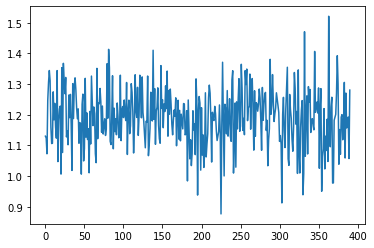

Epoch 6 done.

Average test loss: 1.1972  Accuracy: 2813/ 5000 (56.26%)


Average train loss: 1.1571  Accuracy:28859/50000 (57.72%)

[    0/50000 (  0%)]  Loss: 1.0525
[12800/50000 ( 26%)]  Loss: 1.1399
[25600/50000 ( 51%)]  Loss: 1.1980
[38400/50000 ( 77%)]  Loss: 1.1040


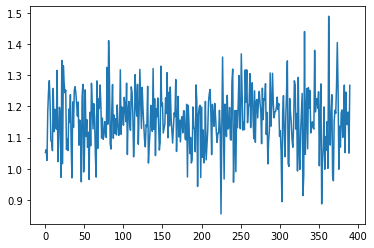

Epoch 7 done.

Average test loss: 1.1816  Accuracy: 2859/ 5000 (57.18%)


Average train loss: 1.1368  Accuracy:29270/50000 (58.54%)

[    0/50000 (  0%)]  Loss: 1.0251
[12800/50000 ( 26%)]  Loss: 1.1192
[25600/50000 ( 51%)]  Loss: 1.1841
[38400/50000 ( 77%)]  Loss: 1.0975


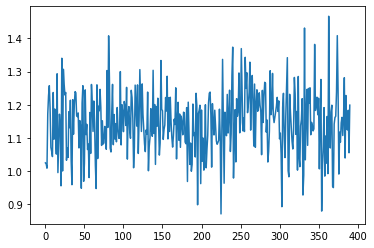

Epoch 8 done.

Average test loss: 1.1779  Accuracy: 2847/ 5000 (56.94%)


Average train loss: 1.1283  Accuracy:29322/50000 (58.64%)

[    0/50000 (  0%)]  Loss: 1.0064
[12800/50000 ( 26%)]  Loss: 1.1245
[25600/50000 ( 51%)]  Loss: 1.1577
[38400/50000 ( 77%)]  Loss: 1.0742


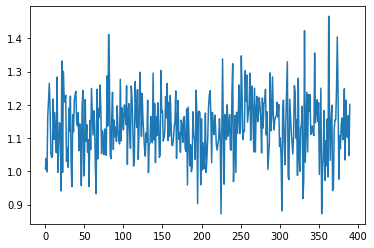

Epoch 9 done.

Average test loss: 1.1708  Accuracy: 2870/ 5000 (57.40%)


Average train loss: 1.1198  Accuracy:29584/50000 (59.17%)

Best So Far:
{'valid_acc': tensor(57.4000, device='cuda:0'), 'train_acc': tensor(59.1680, device='cuda:0'), 'lr': 0.00536169768977384, 'L': 8, 'N': 128, 'D': 512, 'optim': <class 'torch.optim.adam.Adam'>}
[    0/50000 (  0%)]  Loss: 3.3144
[12800/50000 ( 26%)]  Loss: 1.7447
[25600/50000 ( 51%)]  Loss: 1.8237
[38400/50000 ( 77%)]  Loss: 1.6577


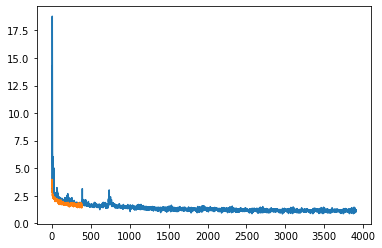

Epoch 0 done.

Average test loss: 1.5494  Accuracy: 2217/ 5000 (44.34%)


Average train loss: 1.5367  Accuracy:21964/50000 (43.93%)

[    0/50000 (  0%)]  Loss: 1.6605
[12800/50000 ( 26%)]  Loss: 1.3787
[25600/50000 ( 51%)]  Loss: 1.4304
[38400/50000 ( 77%)]  Loss: 1.3728


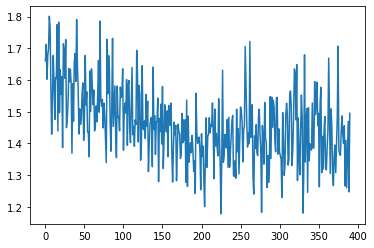

Epoch 1 done.

Average test loss: 1.3931  Accuracy: 2515/ 5000 (50.30%)


Average train loss: 1.3732  Accuracy:25455/50000 (50.91%)

[    0/50000 (  0%)]  Loss: 1.2952
[12800/50000 ( 26%)]  Loss: 1.2613
[25600/50000 ( 51%)]  Loss: 1.3690
[38400/50000 ( 77%)]  Loss: 1.1783


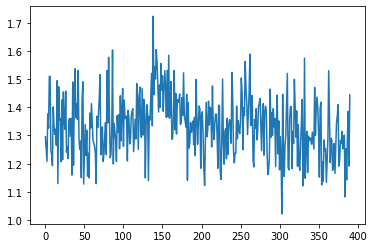

Epoch 2 done.

Average test loss: 1.2972  Accuracy: 2690/ 5000 (53.80%)


Average train loss: 1.2475  Accuracy:27594/50000 (55.19%)

[    0/50000 (  0%)]  Loss: 1.1522
[12800/50000 ( 26%)]  Loss: 1.2571
[25600/50000 ( 51%)]  Loss: 1.1838
[38400/50000 ( 77%)]  Loss: 1.1640


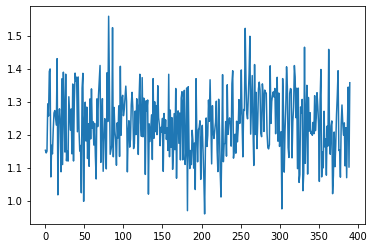

Epoch 3 done.

Average test loss: 1.2396  Accuracy: 2750/ 5000 (55.00%)


Average train loss: 1.1773  Accuracy:28711/50000 (57.42%)

[    0/50000 (  0%)]  Loss: 1.0531
[12800/50000 ( 26%)]  Loss: 1.1782
[25600/50000 ( 51%)]  Loss: 1.1412
[38400/50000 ( 77%)]  Loss: 1.0402


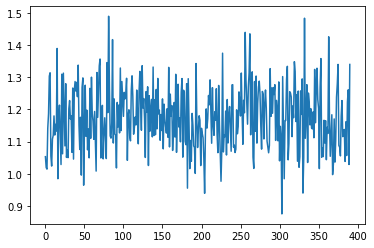

Epoch 4 done.

Average test loss: 1.2114  Accuracy: 2833/ 5000 (56.66%)


Average train loss: 1.1353  Accuracy:29532/50000 (59.06%)

[    0/50000 (  0%)]  Loss: 1.0202
[12800/50000 ( 26%)]  Loss: 1.1070
[25600/50000 ( 51%)]  Loss: 1.1279
[38400/50000 ( 77%)]  Loss: 1.0022


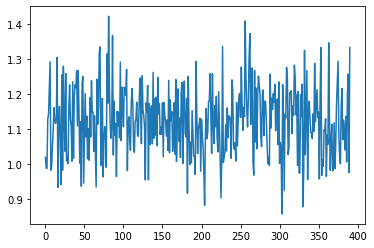

Epoch 5 done.

Average test loss: 1.1901  Accuracy: 2879/ 5000 (57.58%)


Average train loss: 1.0882  Accuracy:30506/50000 (61.01%)

[    0/50000 (  0%)]  Loss: 0.9910
[12800/50000 ( 26%)]  Loss: 1.1138
[25600/50000 ( 51%)]  Loss: 1.0861
[38400/50000 ( 77%)]  Loss: 0.9611


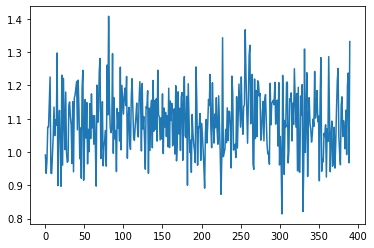

Epoch 6 done.

Average test loss: 1.1875  Accuracy: 2888/ 5000 (57.76%)


Average train loss: 1.0799  Accuracy:30572/50000 (61.14%)

[    0/50000 (  0%)]  Loss: 0.9430
[12800/50000 ( 26%)]  Loss: 1.0842
[25600/50000 ( 51%)]  Loss: 1.0734
[38400/50000 ( 77%)]  Loss: 0.9725


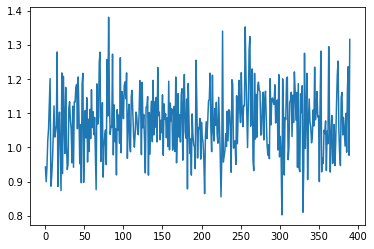

Epoch 7 done.

Average test loss: 1.1794  Accuracy: 2929/ 5000 (58.58%)


Average train loss: 1.0615  Accuracy:30995/50000 (61.99%)

[    0/50000 (  0%)]  Loss: 0.9140
[12800/50000 ( 26%)]  Loss: 1.0746
[25600/50000 ( 51%)]  Loss: 1.0619
[38400/50000 ( 77%)]  Loss: 0.9624


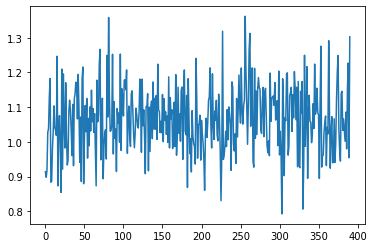

Epoch 8 done.

Average test loss: 1.1777  Accuracy: 2936/ 5000 (58.72%)


Average train loss: 1.0534  Accuracy:31202/50000 (62.40%)

[    0/50000 (  0%)]  Loss: 0.9035
[12800/50000 ( 26%)]  Loss: 1.0531
[25600/50000 ( 51%)]  Loss: 1.0580
[38400/50000 ( 77%)]  Loss: 0.9448


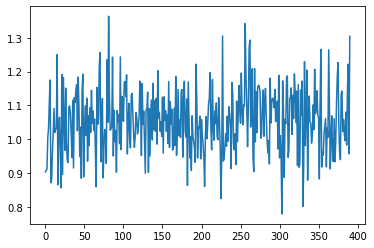

Epoch 9 done.

Average test loss: 1.1771  Accuracy: 2940/ 5000 (58.80%)


Average train loss: 1.0474  Accuracy:31249/50000 (62.50%)

Best So Far:
{'valid_acc': tensor(58.8000, device='cuda:0'), 'train_acc': tensor(62.4980, device='cuda:0'), 'lr': 0.0011275683251840245, 'L': 8, 'N': 128, 'D': 512, 'optim': <class 'torch.optim.adam.Adam'>}
[    0/50000 (  0%)]  Loss: 3.0654
[12800/50000 ( 26%)]  Loss: 2.1592
[25600/50000 ( 51%)]  Loss: 2.0337
[38400/50000 ( 77%)]  Loss: 1.8212


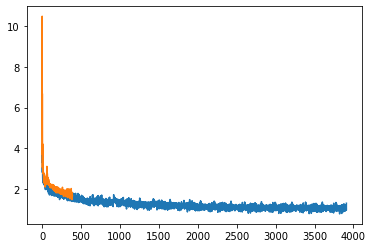

Epoch 0 done.

Average test loss: 1.6923  Accuracy: 1887/ 5000 (37.74%)


Average train loss: 1.7031  Accuracy:18547/50000 (37.09%)

[    0/50000 (  0%)]  Loss: 1.6909
[12800/50000 ( 26%)]  Loss: 1.5086
[25600/50000 ( 51%)]  Loss: 1.5039
[38400/50000 ( 77%)]  Loss: 1.4195


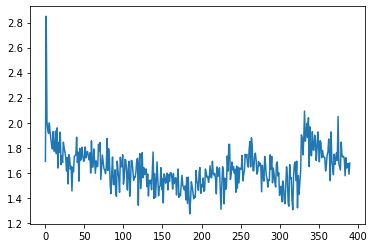

Epoch 1 done.

Average test loss: 1.6681  Accuracy: 1993/ 5000 (39.86%)


Average train loss: 1.6686  Accuracy:19606/50000 (39.21%)

[    0/50000 (  0%)]  Loss: 1.6042
[12800/50000 ( 26%)]  Loss: 1.3835
[25600/50000 ( 51%)]  Loss: 1.3376
[38400/50000 ( 77%)]  Loss: 1.3395


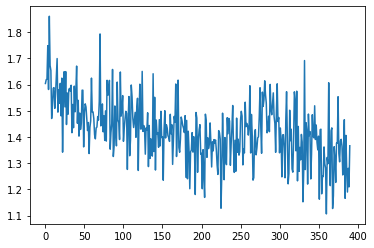

Epoch 2 done.

Average test loss: 1.3149  Accuracy: 2567/ 5000 (51.34%)


Average train loss: 1.2956  Accuracy:26075/50000 (52.15%)

[    0/50000 (  0%)]  Loss: 1.2135
[12800/50000 ( 26%)]  Loss: 1.2633
[25600/50000 ( 51%)]  Loss: 1.2233
[38400/50000 ( 77%)]  Loss: 1.1109


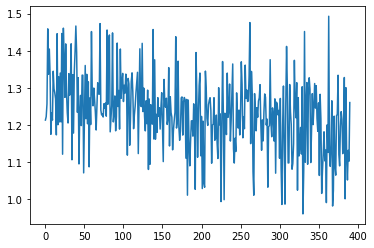

Epoch 3 done.

Average test loss: 1.2003  Accuracy: 2852/ 5000 (57.04%)


Average train loss: 1.1549  Accuracy:29127/50000 (58.25%)

[    0/50000 (  0%)]  Loss: 1.0825
[12800/50000 ( 26%)]  Loss: 1.1962
[25600/50000 ( 51%)]  Loss: 1.4040
[38400/50000 ( 77%)]  Loss: 1.1604


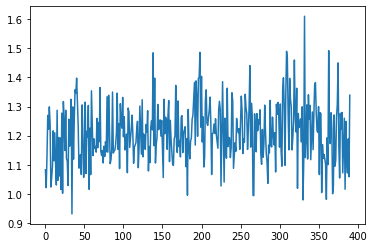

Epoch 4 done.

Average test loss: 1.2330  Accuracy: 2768/ 5000 (55.36%)


Average train loss: 1.1928  Accuracy:28531/50000 (57.06%)

[    0/50000 (  0%)]  Loss: 1.1494
[12800/50000 ( 26%)]  Loss: 1.1684
[25600/50000 ( 51%)]  Loss: 1.1442
[38400/50000 ( 77%)]  Loss: 0.9813


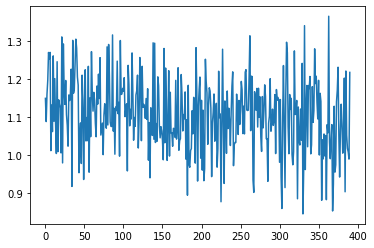

Epoch 5 done.

Average test loss: 1.1254  Accuracy: 2995/ 5000 (59.90%)


Average train loss: 1.0508  Accuracy:31170/50000 (62.34%)

[    0/50000 (  0%)]  Loss: 1.0123
[12800/50000 ( 26%)]  Loss: 1.1255
[25600/50000 ( 51%)]  Loss: 1.0780
[38400/50000 ( 77%)]  Loss: 0.9384


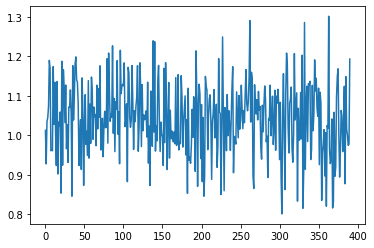

Epoch 6 done.

Average test loss: 1.1002  Accuracy: 3032/ 5000 (60.64%)


Average train loss: 1.0038  Accuracy:32037/50000 (64.07%)

[    0/50000 (  0%)]  Loss: 0.9656
[12800/50000 ( 26%)]  Loss: 1.0687
[25600/50000 ( 51%)]  Loss: 1.0396
[38400/50000 ( 77%)]  Loss: 0.9148


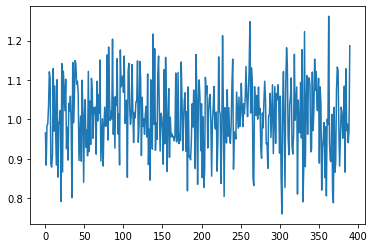

Epoch 7 done.

Average test loss: 1.0910  Accuracy: 3062/ 5000 (61.24%)


Average train loss: 0.9888  Accuracy:32309/50000 (64.62%)

[    0/50000 (  0%)]  Loss: 0.9325
[12800/50000 ( 26%)]  Loss: 1.0457
[25600/50000 ( 51%)]  Loss: 1.0345
[38400/50000 ( 77%)]  Loss: 0.9026


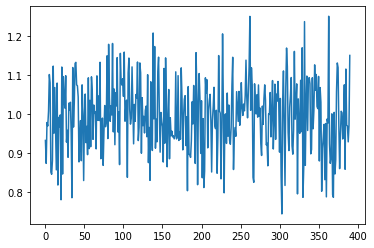

Epoch 8 done.

Average test loss: 1.0891  Accuracy: 3067/ 5000 (61.34%)


Average train loss: 0.9781  Accuracy:32537/50000 (65.07%)

[    0/50000 (  0%)]  Loss: 0.9309
[12800/50000 ( 26%)]  Loss: 1.0241
[25600/50000 ( 51%)]  Loss: 1.0163
[38400/50000 ( 77%)]  Loss: 0.8878


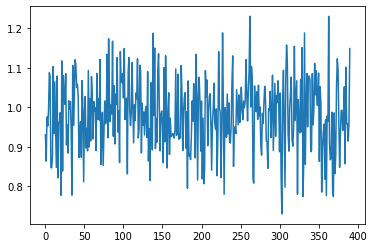

Epoch 9 done.

Average test loss: 1.0833  Accuracy: 3077/ 5000 (61.54%)


Average train loss: 0.9680  Accuracy:32730/50000 (65.46%)

Best So Far:
{'valid_acc': tensor(61.5400, device='cuda:0'), 'train_acc': tensor(65.4600, device='cuda:0'), 'lr': 0.0035218805677437685, 'L': 8, 'N': 128, 'D': 512, 'optim': <class 'torch.optim.adam.Adam'>}
[    0/50000 (  0%)]  Loss: 2.8034
[12800/50000 ( 26%)]  Loss: 2.3209
[25600/50000 ( 51%)]  Loss: 2.3039
[38400/50000 ( 77%)]  Loss: 2.2498


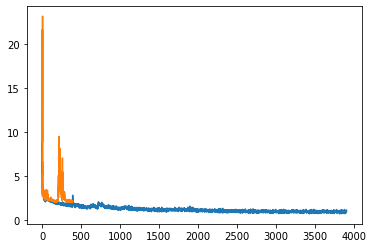

Epoch 0 done.

Average test loss: 2.3354  Accuracy: 1125/ 5000 (22.50%)


Average train loss: 2.2856  Accuracy:10739/50000 (21.48%)

[    0/50000 (  0%)]  Loss: 2.1003
[12800/50000 ( 26%)]  Loss: 3.2200
[25600/50000 ( 51%)]  Loss: 1.6653
[38400/50000 ( 77%)]  Loss: 1.5928


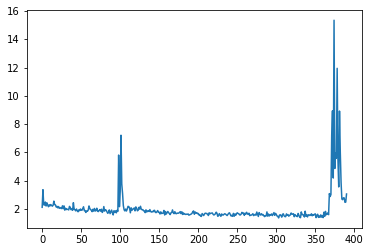

Epoch 1 done.

Average test loss: 3.6029  Accuracy: 1022/ 5000 (20.44%)


Average train loss: 3.3613  Accuracy:10209/50000 (20.42%)

[    0/50000 (  0%)]  Loss: 3.8541
[12800/50000 ( 26%)]  Loss: 1.5709
[25600/50000 ( 51%)]  Loss: 1.4328
[38400/50000 ( 77%)]  Loss: 1.5409


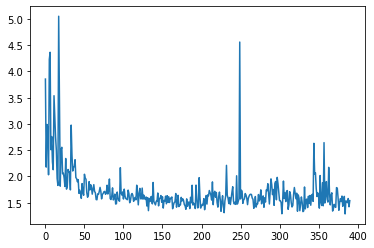

Epoch 2 done.

Average test loss: 1.5059  Accuracy: 2363/ 5000 (47.26%)


Average train loss: 1.5121  Accuracy:23240/50000 (46.48%)

[    0/50000 (  0%)]  Loss: 1.5748
[12800/50000 ( 26%)]  Loss: 1.3011
[25600/50000 ( 51%)]  Loss: 1.3138
[38400/50000 ( 77%)]  Loss: 1.3396


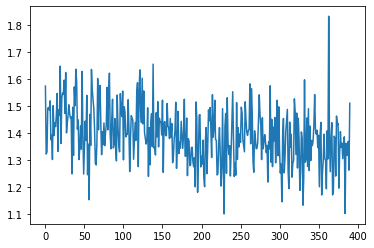

Epoch 3 done.

Average test loss: 1.3241  Accuracy: 2565/ 5000 (51.30%)


Average train loss: 1.3110  Accuracy:26175/50000 (52.35%)

[    0/50000 (  0%)]  Loss: 1.2404
[12800/50000 ( 26%)]  Loss: 1.2203
[25600/50000 ( 51%)]  Loss: 1.2516
[38400/50000 ( 77%)]  Loss: 1.2207


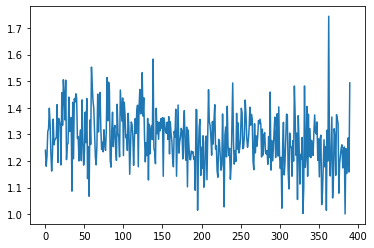

Epoch 4 done.

Average test loss: 1.2587  Accuracy: 2717/ 5000 (54.34%)


Average train loss: 1.2256  Accuracy:27919/50000 (55.84%)

[    0/50000 (  0%)]  Loss: 1.1683
[12800/50000 ( 26%)]  Loss: 1.1306
[25600/50000 ( 51%)]  Loss: 1.1990
[38400/50000 ( 77%)]  Loss: 1.1359


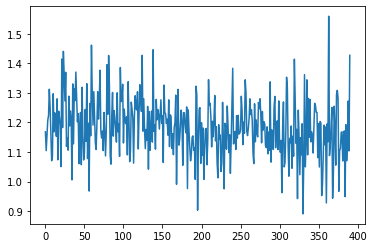

Epoch 5 done.

Average test loss: 1.2007  Accuracy: 2864/ 5000 (57.28%)


Average train loss: 1.1460  Accuracy:29350/50000 (58.70%)

[    0/50000 (  0%)]  Loss: 1.0537
[12800/50000 ( 26%)]  Loss: 1.0879
[25600/50000 ( 51%)]  Loss: 1.1461
[38400/50000 ( 77%)]  Loss: 1.0676


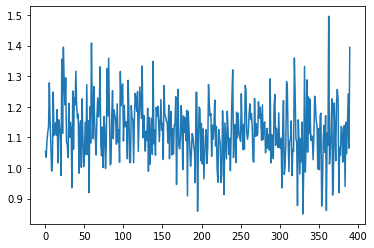

Epoch 6 done.

Average test loss: 1.1783  Accuracy: 2895/ 5000 (57.90%)


Average train loss: 1.1049  Accuracy:30037/50000 (60.07%)

[    0/50000 (  0%)]  Loss: 0.9892
[12800/50000 ( 26%)]  Loss: 1.0587
[25600/50000 ( 51%)]  Loss: 1.1205
[38400/50000 ( 77%)]  Loss: 1.0229


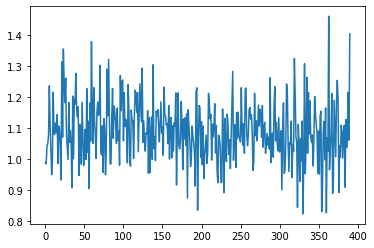

Epoch 7 done.

Average test loss: 1.1749  Accuracy: 2909/ 5000 (58.18%)


Average train loss: 1.0913  Accuracy:30334/50000 (60.67%)

[    0/50000 (  0%)]  Loss: 0.9553
[12800/50000 ( 26%)]  Loss: 1.0476
[25600/50000 ( 51%)]  Loss: 1.1098
[38400/50000 ( 77%)]  Loss: 1.0068


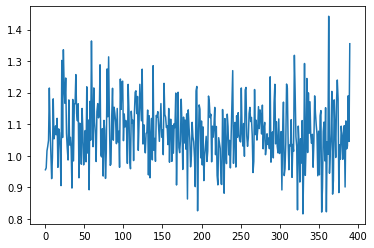

Epoch 8 done.

Average test loss: 1.1520  Accuracy: 2950/ 5000 (59.00%)


Average train loss: 1.0634  Accuracy:30781/50000 (61.56%)

[    0/50000 (  0%)]  Loss: 0.9408
[12800/50000 ( 26%)]  Loss: 1.0353
[25600/50000 ( 51%)]  Loss: 1.0903
[38400/50000 ( 77%)]  Loss: 0.9849


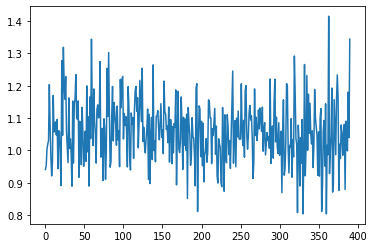

Epoch 9 done.

Average test loss: 1.1548  Accuracy: 2970/ 5000 (59.40%)


Average train loss: 1.0581  Accuracy:30960/50000 (61.92%)

Best So Far:
{'valid_acc': tensor(61.5400, device='cuda:0'), 'train_acc': tensor(65.4600, device='cuda:0'), 'lr': 0.0035218805677437685, 'L': 8, 'N': 128, 'D': 512, 'optim': <class 'torch.optim.adam.Adam'>}
[    0/50000 (  0%)]  Loss: 2.9912
[12800/50000 ( 26%)]  Loss: 1.9724
[25600/50000 ( 51%)]  Loss: 1.9361
[38400/50000 ( 77%)]  Loss: 1.7703


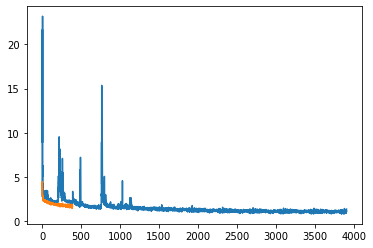

Epoch 0 done.

Average test loss: 1.6600  Accuracy: 1982/ 5000 (39.64%)


Average train loss: 1.6650  Accuracy:19409/50000 (38.82%)

[    0/50000 (  0%)]  Loss: 1.6688
[12800/50000 ( 26%)]  Loss: 1.6676
[25600/50000 ( 51%)]  Loss: 1.5517
[38400/50000 ( 77%)]  Loss: 1.4765


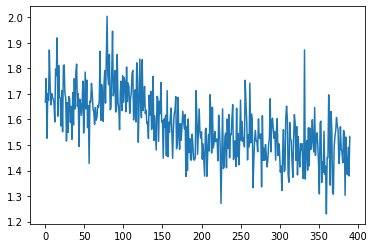

Epoch 1 done.

Average test loss: 1.4542  Accuracy: 2357/ 5000 (47.14%)


Average train loss: 1.4448  Accuracy:23704/50000 (47.41%)

[    0/50000 (  0%)]  Loss: 1.3761
[12800/50000 ( 26%)]  Loss: 1.3075
[25600/50000 ( 51%)]  Loss: 1.3532
[38400/50000 ( 77%)]  Loss: 1.2705


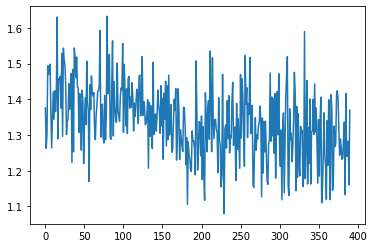

Epoch 2 done.

Average test loss: 1.3175  Accuracy: 2661/ 5000 (53.22%)


Average train loss: 1.2681  Accuracy:27430/50000 (54.86%)

[    0/50000 (  0%)]  Loss: 1.1298
[12800/50000 ( 26%)]  Loss: 1.1660
[25600/50000 ( 51%)]  Loss: 1.1748
[38400/50000 ( 77%)]  Loss: 1.1281


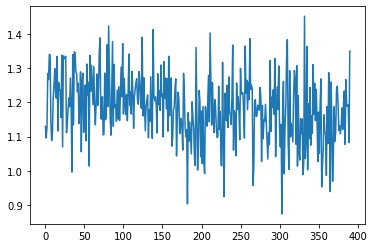

Epoch 3 done.

Average test loss: 1.2201  Accuracy: 2854/ 5000 (57.08%)


Average train loss: 1.1368  Accuracy:29560/50000 (59.12%)

[    0/50000 (  0%)]  Loss: 0.9920
[12800/50000 ( 26%)]  Loss: 1.0749
[25600/50000 ( 51%)]  Loss: 1.1137
[38400/50000 ( 77%)]  Loss: 1.0555


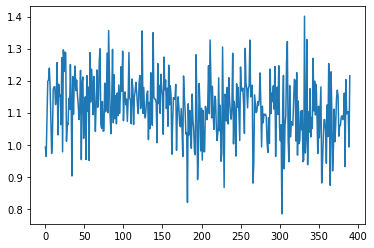

Epoch 4 done.

Average test loss: 1.1937  Accuracy: 2904/ 5000 (58.08%)


Average train loss: 1.0678  Accuracy:30860/50000 (61.72%)

[    0/50000 (  0%)]  Loss: 0.9621
[12800/50000 ( 26%)]  Loss: 1.0001
[25600/50000 ( 51%)]  Loss: 1.0747
[38400/50000 ( 77%)]  Loss: 0.9814


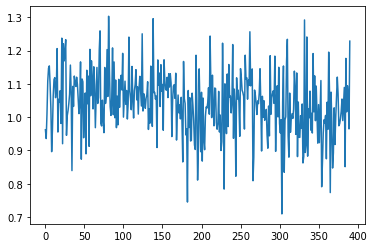

Epoch 5 done.

Average test loss: 1.1755  Accuracy: 2955/ 5000 (59.10%)


Average train loss: 1.0054  Accuracy:32016/50000 (64.03%)

[    0/50000 (  0%)]  Loss: 0.8317
[12800/50000 ( 26%)]  Loss: 0.9462
[25600/50000 ( 51%)]  Loss: 1.0341
[38400/50000 ( 77%)]  Loss: 0.9410


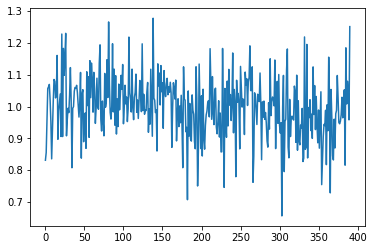

Epoch 6 done.

Average test loss: 1.1757  Accuracy: 2949/ 5000 (58.98%)


Average train loss: 0.9828  Accuracy:32441/50000 (64.88%)

[    0/50000 (  0%)]  Loss: 0.7911
[12800/50000 ( 26%)]  Loss: 0.9211
[25600/50000 ( 51%)]  Loss: 1.0233
[38400/50000 ( 77%)]  Loss: 0.9180


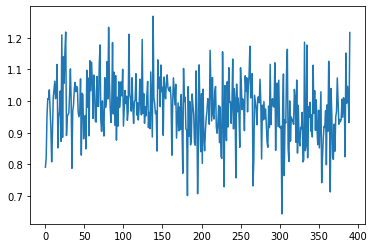

Epoch 7 done.

Average test loss: 1.1714  Accuracy: 2960/ 5000 (59.20%)


Average train loss: 0.9673  Accuracy:32733/50000 (65.47%)

[    0/50000 (  0%)]  Loss: 0.7588
[12800/50000 ( 26%)]  Loss: 0.9018
[25600/50000 ( 51%)]  Loss: 1.0181
[38400/50000 ( 77%)]  Loss: 0.9081


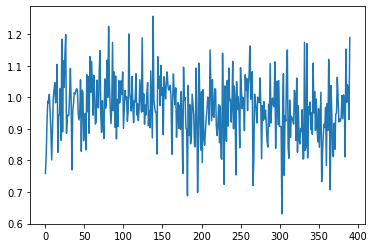

Epoch 8 done.

Average test loss: 1.1707  Accuracy: 2973/ 5000 (59.46%)


Average train loss: 0.9589  Accuracy:32867/50000 (65.73%)

[    0/50000 (  0%)]  Loss: 0.7554
[12800/50000 ( 26%)]  Loss: 0.8985
[25600/50000 ( 51%)]  Loss: 1.0017
[38400/50000 ( 77%)]  Loss: 0.8912


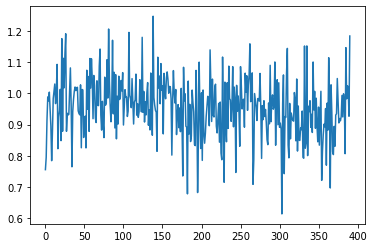

Epoch 9 done.

Average test loss: 1.1701  Accuracy: 2974/ 5000 (59.48%)


Average train loss: 0.9526  Accuracy:32956/50000 (65.91%)

Best So Far:
{'valid_acc': tensor(61.5400, device='cuda:0'), 'train_acc': tensor(65.4600, device='cuda:0'), 'lr': 0.0035218805677437685, 'L': 8, 'N': 128, 'D': 512, 'optim': <class 'torch.optim.adam.Adam'>}
[    0/50000 (  0%)]  Loss: 2.9562
[12800/50000 ( 26%)]  Loss: 2.0185
[25600/50000 ( 51%)]  Loss: 1.8745
[38400/50000 ( 77%)]  Loss: 1.8153


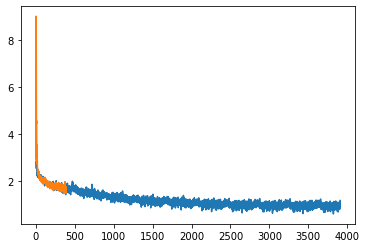

Epoch 0 done.

Average test loss: 1.6236  Accuracy: 2056/ 5000 (41.12%)


Average train loss: 1.6296  Accuracy:19948/50000 (39.90%)

[    0/50000 (  0%)]  Loss: 1.7182
[12800/50000 ( 26%)]  Loss: 1.4903
[25600/50000 ( 51%)]  Loss: 1.7436
[38400/50000 ( 77%)]  Loss: 1.4514


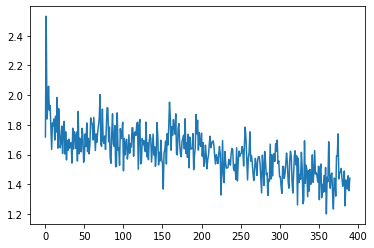

Epoch 1 done.

Average test loss: 1.3728  Accuracy: 2483/ 5000 (49.66%)


Average train loss: 1.3747  Accuracy:24937/50000 (49.87%)

[    0/50000 (  0%)]  Loss: 1.3632
[12800/50000 ( 26%)]  Loss: 1.2716
[25600/50000 ( 51%)]  Loss: 1.3579
[38400/50000 ( 77%)]  Loss: 1.2141


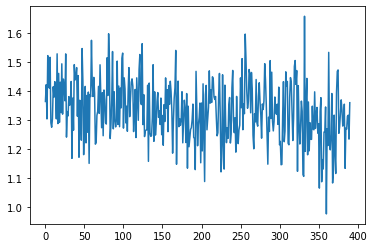

Epoch 2 done.

Average test loss: 1.2515  Accuracy: 2730/ 5000 (54.60%)


Average train loss: 1.2335  Accuracy:27776/50000 (55.55%)

[    0/50000 (  0%)]  Loss: 1.1594
[12800/50000 ( 26%)]  Loss: 1.2571
[25600/50000 ( 51%)]  Loss: 1.2738
[38400/50000 ( 77%)]  Loss: 1.0830


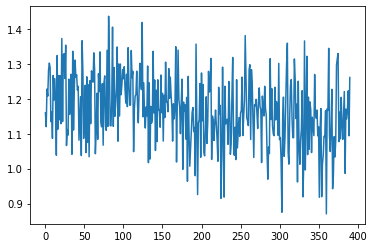

Epoch 3 done.

Average test loss: 1.1370  Accuracy: 2975/ 5000 (59.50%)


Average train loss: 1.0879  Accuracy:30324/50000 (60.65%)

[    0/50000 (  0%)]  Loss: 1.0113
[12800/50000 ( 26%)]  Loss: 1.1652
[25600/50000 ( 51%)]  Loss: 1.1930
[38400/50000 ( 77%)]  Loss: 1.0543


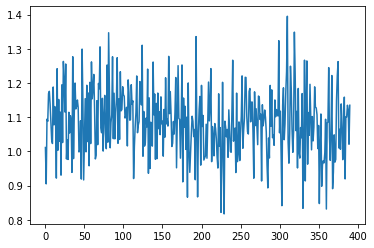

Epoch 4 done.

Average test loss: 1.0858  Accuracy: 3075/ 5000 (61.50%)


Average train loss: 1.0172  Accuracy:31821/50000 (63.64%)

[    0/50000 (  0%)]  Loss: 0.9575
[12800/50000 ( 26%)]  Loss: 1.1075
[25600/50000 ( 51%)]  Loss: 1.0970
[38400/50000 ( 77%)]  Loss: 0.9422


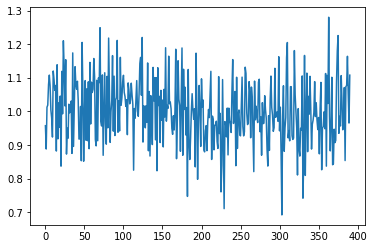

Epoch 5 done.

Average test loss: 1.0767  Accuracy: 3088/ 5000 (61.76%)


Average train loss: 0.9744  Accuracy:32708/50000 (65.42%)

[    0/50000 (  0%)]  Loss: 0.9338
[12800/50000 ( 26%)]  Loss: 1.0438
[25600/50000 ( 51%)]  Loss: 1.0438
[38400/50000 ( 77%)]  Loss: 0.8924


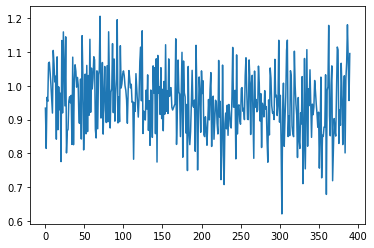

Epoch 6 done.

Average test loss: 1.0568  Accuracy: 3122/ 5000 (62.44%)


Average train loss: 0.9311  Accuracy:33390/50000 (66.78%)

[    0/50000 (  0%)]  Loss: 0.8586
[12800/50000 ( 26%)]  Loss: 1.0028
[25600/50000 ( 51%)]  Loss: 1.0231
[38400/50000 ( 77%)]  Loss: 0.8681


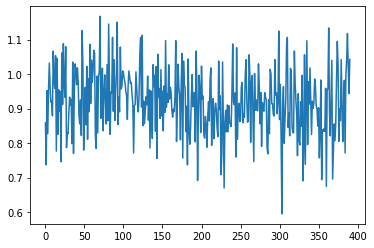

Epoch 7 done.

Average test loss: 1.0413  Accuracy: 3157/ 5000 (63.14%)


Average train loss: 0.9026  Accuracy:33911/50000 (67.82%)

[    0/50000 (  0%)]  Loss: 0.7938
[12800/50000 ( 26%)]  Loss: 0.9843
[25600/50000 ( 51%)]  Loss: 1.0078
[38400/50000 ( 77%)]  Loss: 0.8597


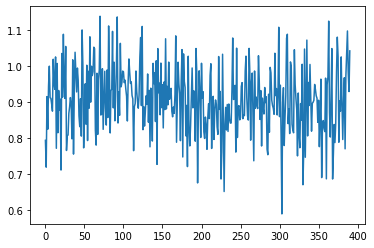

Epoch 8 done.

Average test loss: 1.0429  Accuracy: 3145/ 5000 (62.90%)


Average train loss: 0.8946  Accuracy:34078/50000 (68.16%)

[    0/50000 (  0%)]  Loss: 0.7851
[12800/50000 ( 26%)]  Loss: 0.9818
[25600/50000 ( 51%)]  Loss: 0.9931
[38400/50000 ( 77%)]  Loss: 0.8556


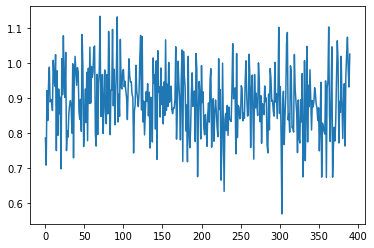

Epoch 9 done.

Average test loss: 1.0365  Accuracy: 3152/ 5000 (63.04%)


Average train loss: 0.8813  Accuracy:34345/50000 (68.69%)

Best So Far:
{'valid_acc': tensor(63.0400, device='cuda:0'), 'train_acc': tensor(68.6900, device='cuda:0'), 'lr': 0.0035287969387649185, 'L': 8, 'N': 128, 'D': 512, 'optim': <class 'torch.optim.adam.Adam'>}
[    0/50000 (  0%)]  Loss: 3.4459
[12800/50000 ( 26%)]  Loss: 1.9706
[25600/50000 ( 51%)]  Loss: 1.9613
[38400/50000 ( 77%)]  Loss: 1.6562


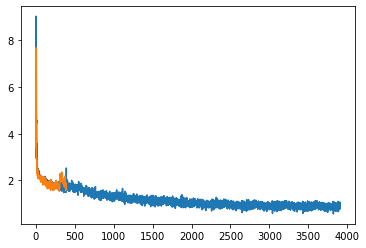

Epoch 0 done.

Average test loss: 1.8806  Accuracy: 1604/ 5000 (32.08%)


Average train loss: 1.8989  Accuracy:15660/50000 (31.32%)

[    0/50000 (  0%)]  Loss: 1.8676
[12800/50000 ( 26%)]  Loss: 1.7013
[25600/50000 ( 51%)]  Loss: 1.9703
[38400/50000 ( 77%)]  Loss: 1.6532


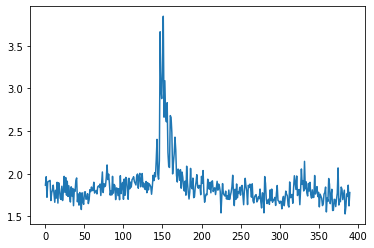

Epoch 1 done.

Average test loss: 1.7120  Accuracy: 1855/ 5000 (37.10%)


Average train loss: 1.7191  Accuracy:18253/50000 (36.51%)

[    0/50000 (  0%)]  Loss: 1.7713
[12800/50000 ( 26%)]  Loss: 1.5794
[25600/50000 ( 51%)]  Loss: 1.5320
[38400/50000 ( 77%)]  Loss: 1.5565


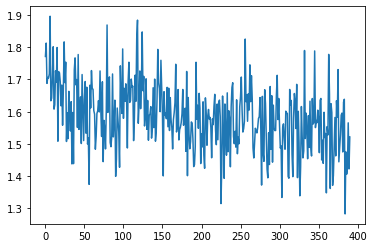

Epoch 2 done.

Average test loss: 1.4875  Accuracy: 2291/ 5000 (45.82%)


Average train loss: 1.4884  Accuracy:22424/50000 (44.85%)

[    0/50000 (  0%)]  Loss: 1.4911
[12800/50000 ( 26%)]  Loss: 1.4601
[25600/50000 ( 51%)]  Loss: 1.4185
[38400/50000 ( 77%)]  Loss: 1.4637


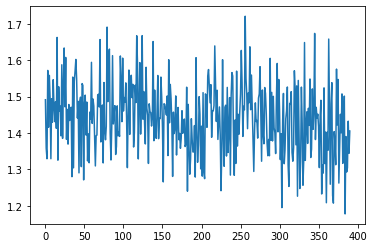

Epoch 3 done.

Average test loss: 1.3820  Accuracy: 2500/ 5000 (50.00%)


Average train loss: 1.3727  Accuracy:24909/50000 (49.82%)

[    0/50000 (  0%)]  Loss: 1.2933
[12800/50000 ( 26%)]  Loss: 1.3678
[25600/50000 ( 51%)]  Loss: 1.3801
[38400/50000 ( 77%)]  Loss: 1.3562


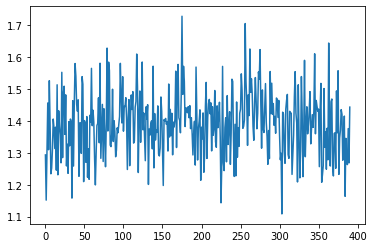

Epoch 4 done.

Average test loss: 1.3562  Accuracy: 2521/ 5000 (50.42%)


Average train loss: 1.3359  Accuracy:25658/50000 (51.32%)

[    0/50000 (  0%)]  Loss: 1.2704
[12800/50000 ( 26%)]  Loss: 1.3227
[25600/50000 ( 51%)]  Loss: 1.3305
[38400/50000 ( 77%)]  Loss: 1.2654


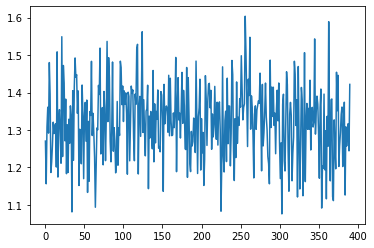

Epoch 5 done.

Average test loss: 1.3140  Accuracy: 2609/ 5000 (52.18%)


Average train loss: 1.2845  Accuracy:26644/50000 (53.29%)

[    0/50000 (  0%)]  Loss: 1.2252
[12800/50000 ( 26%)]  Loss: 1.2886
[25600/50000 ( 51%)]  Loss: 1.2794
[38400/50000 ( 77%)]  Loss: 1.2385


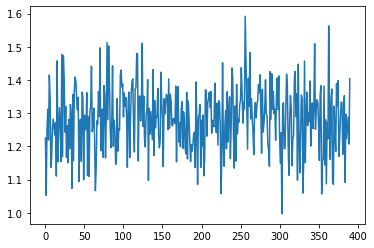

Epoch 6 done.

Average test loss: 1.2891  Accuracy: 2655/ 5000 (53.10%)


Average train loss: 1.2566  Accuracy:27157/50000 (54.31%)

[    0/50000 (  0%)]  Loss: 1.1845
[12800/50000 ( 26%)]  Loss: 1.2588
[25600/50000 ( 51%)]  Loss: 1.2719
[38400/50000 ( 77%)]  Loss: 1.2024


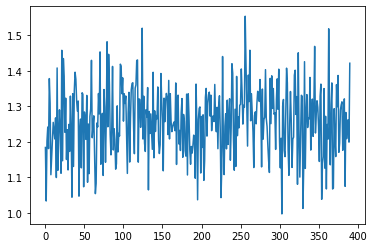

Epoch 7 done.

Average test loss: 1.2799  Accuracy: 2657/ 5000 (53.14%)


Average train loss: 1.2401  Accuracy:27509/50000 (55.02%)

[    0/50000 (  0%)]  Loss: 1.1659
[12800/50000 ( 26%)]  Loss: 1.2368
[25600/50000 ( 51%)]  Loss: 1.2756
[38400/50000 ( 77%)]  Loss: 1.1879


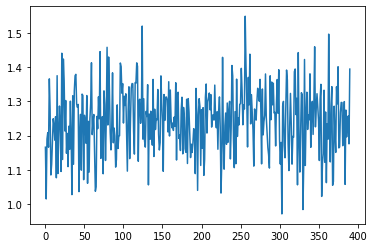

Epoch 8 done.

Average test loss: 1.2736  Accuracy: 2666/ 5000 (53.32%)


Average train loss: 1.2303  Accuracy:27714/50000 (55.43%)

[    0/50000 (  0%)]  Loss: 1.1669
[12800/50000 ( 26%)]  Loss: 1.2188
[25600/50000 ( 51%)]  Loss: 1.2400
[38400/50000 ( 77%)]  Loss: 1.1755


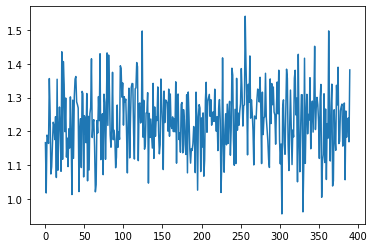

Epoch 9 done.

Average test loss: 1.2662  Accuracy: 2703/ 5000 (54.06%)


Average train loss: 1.2192  Accuracy:27904/50000 (55.81%)

Best So Far:
{'valid_acc': tensor(63.0400, device='cuda:0'), 'train_acc': tensor(68.6900, device='cuda:0'), 'lr': 0.0035287969387649185, 'L': 8, 'N': 128, 'D': 512, 'optim': <class 'torch.optim.adam.Adam'>}
[    0/50000 (  0%)]  Loss: 3.1639
[12800/50000 ( 26%)]  Loss: 2.0607
[25600/50000 ( 51%)]  Loss: 2.8029
[38400/50000 ( 77%)]  Loss: 2.5755


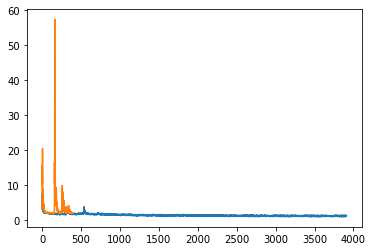

Epoch 0 done.

Average test loss: 2.0219  Accuracy: 1310/ 5000 (26.20%)


Average train loss: 2.0157  Accuracy:12447/50000 (24.89%)

[    0/50000 (  0%)]  Loss: 2.0857
[12800/50000 ( 26%)]  Loss: 1.8053
[25600/50000 ( 51%)]  Loss: 1.7431
[38400/50000 ( 77%)]  Loss: 1.7111


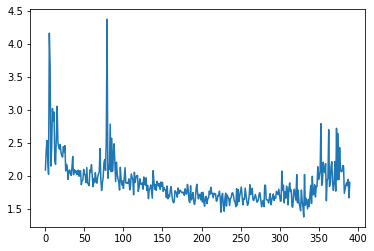

Epoch 1 done.

Average test loss: 2.0274  Accuracy: 1698/ 5000 (33.96%)


Average train loss: 2.0223  Accuracy:16795/50000 (33.59%)

[    0/50000 (  0%)]  Loss: 1.7817
[12800/50000 ( 26%)]  Loss: 1.4468
[25600/50000 ( 51%)]  Loss: 1.4023
[38400/50000 ( 77%)]  Loss: 1.5120


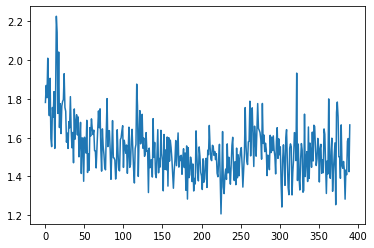

Epoch 2 done.

Average test loss: 1.4611  Accuracy: 2389/ 5000 (47.78%)


Average train loss: 1.4519  Accuracy:23452/50000 (46.90%)

[    0/50000 (  0%)]  Loss: 1.3748
[12800/50000 ( 26%)]  Loss: 1.3220
[25600/50000 ( 51%)]  Loss: 1.2728
[38400/50000 ( 77%)]  Loss: 1.2527


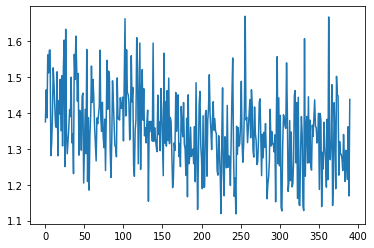

Epoch 3 done.

Average test loss: 1.3076  Accuracy: 2654/ 5000 (53.08%)


Average train loss: 1.2939  Accuracy:26544/50000 (53.09%)

[    0/50000 (  0%)]  Loss: 1.1585
[12800/50000 ( 26%)]  Loss: 1.2424
[25600/50000 ( 51%)]  Loss: 1.1607
[38400/50000 ( 77%)]  Loss: 1.1712


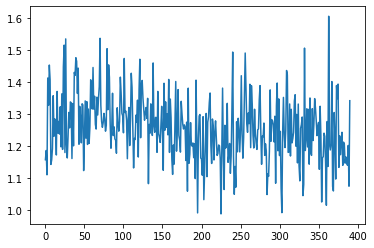

Epoch 4 done.

Average test loss: 1.2246  Accuracy: 2803/ 5000 (56.06%)


Average train loss: 1.1838  Accuracy:28361/50000 (56.72%)

[    0/50000 (  0%)]  Loss: 1.0982
[12800/50000 ( 26%)]  Loss: 1.1541
[25600/50000 ( 51%)]  Loss: 1.0908
[38400/50000 ( 77%)]  Loss: 1.0531


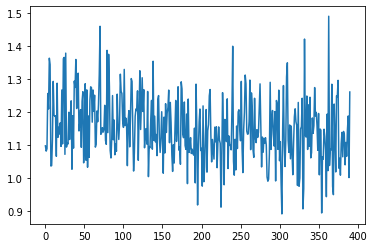

Epoch 5 done.

Average test loss: 1.1734  Accuracy: 2926/ 5000 (58.52%)


Average train loss: 1.1084  Accuracy:29826/50000 (59.65%)

[    0/50000 (  0%)]  Loss: 1.0414
[12800/50000 ( 26%)]  Loss: 1.1200
[25600/50000 ( 51%)]  Loss: 1.0325
[38400/50000 ( 77%)]  Loss: 1.0076


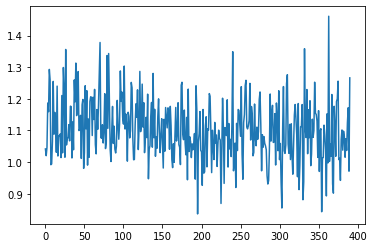

Epoch 6 done.

Average test loss: 1.1447  Accuracy: 2980/ 5000 (59.60%)


Average train loss: 1.0668  Accuracy:30711/50000 (61.42%)

[    0/50000 (  0%)]  Loss: 0.9927
[12800/50000 ( 26%)]  Loss: 1.0821
[25600/50000 ( 51%)]  Loss: 1.0080
[38400/50000 ( 77%)]  Loss: 0.9860


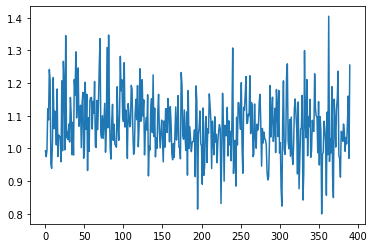

Epoch 7 done.

Average test loss: 1.1345  Accuracy: 3008/ 5000 (60.16%)


Average train loss: 1.0510  Accuracy:30990/50000 (61.98%)

[    0/50000 (  0%)]  Loss: 0.9732
[12800/50000 ( 26%)]  Loss: 1.0686
[25600/50000 ( 51%)]  Loss: 0.9974
[38400/50000 ( 77%)]  Loss: 0.9729


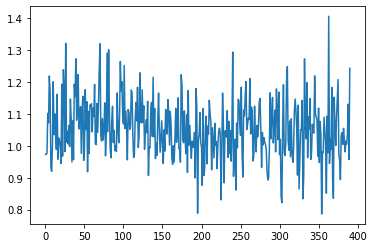

Epoch 8 done.

Average test loss: 1.1254  Accuracy: 3028/ 5000 (60.56%)


Average train loss: 1.0369  Accuracy:31276/50000 (62.55%)

[    0/50000 (  0%)]  Loss: 0.9607
[12800/50000 ( 26%)]  Loss: 1.0489
[25600/50000 ( 51%)]  Loss: 0.9774
[38400/50000 ( 77%)]  Loss: 0.9507


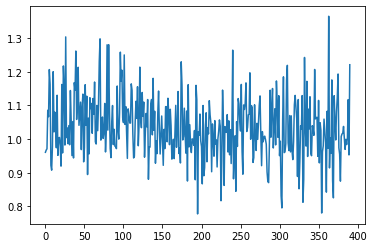

Epoch 9 done.

Average test loss: 1.1179  Accuracy: 3053/ 5000 (61.06%)


Average train loss: 1.0256  Accuracy:31456/50000 (62.91%)

Best So Far:
{'valid_acc': tensor(63.0400, device='cuda:0'), 'train_acc': tensor(68.6900, device='cuda:0'), 'lr': 0.0035287969387649185, 'L': 8, 'N': 128, 'D': 512, 'optim': <class 'torch.optim.adam.Adam'>}
[    0/50000 (  0%)]  Loss: 3.0475
[12800/50000 ( 26%)]  Loss: 2.5109
[25600/50000 ( 51%)]  Loss: 1.9739
[38400/50000 ( 77%)]  Loss: 1.7173


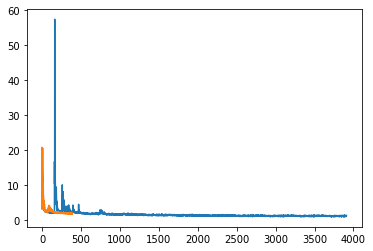

Epoch 0 done.

Average test loss: 1.6984  Accuracy: 1832/ 5000 (36.64%)


Average train loss: 1.7142  Accuracy:17637/50000 (35.27%)

[    0/50000 (  0%)]  Loss: 1.8049
[12800/50000 ( 26%)]  Loss: 1.8053
[25600/50000 ( 51%)]  Loss: 1.7987
[38400/50000 ( 77%)]  Loss: 1.7647


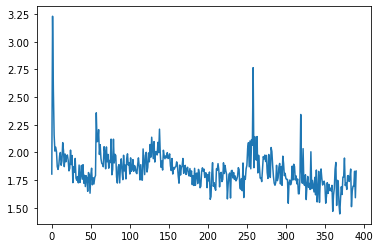

Epoch 1 done.

Average test loss: 1.8615  Accuracy: 1681/ 5000 (33.62%)


Average train loss: 1.8926  Accuracy:16480/50000 (32.96%)

[    0/50000 (  0%)]  Loss: 1.7765
[12800/50000 ( 26%)]  Loss: 1.4923
[25600/50000 ( 51%)]  Loss: 1.5530
[38400/50000 ( 77%)]  Loss: 1.6472


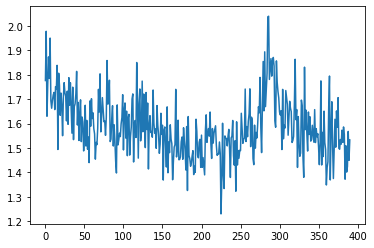

Epoch 2 done.

Average test loss: 1.5013  Accuracy: 2238/ 5000 (44.76%)


Average train loss: 1.5071  Accuracy:22180/50000 (44.36%)

[    0/50000 (  0%)]  Loss: 1.4262
[12800/50000 ( 26%)]  Loss: 1.3639
[25600/50000 ( 51%)]  Loss: 1.4201
[38400/50000 ( 77%)]  Loss: 1.3765


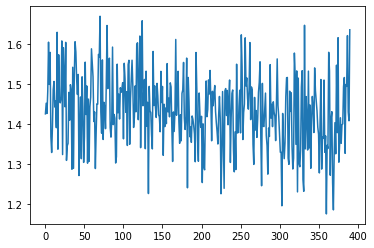

Epoch 3 done.

Average test loss: 1.5647  Accuracy: 2245/ 5000 (44.90%)


Average train loss: 1.5560  Accuracy:22314/50000 (44.63%)

[    0/50000 (  0%)]  Loss: 1.5105
[12800/50000 ( 26%)]  Loss: 1.3657
[25600/50000 ( 51%)]  Loss: 1.4103
[38400/50000 ( 77%)]  Loss: 1.4121


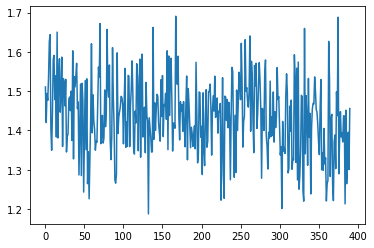

Epoch 4 done.

Average test loss: 1.3710  Accuracy: 2535/ 5000 (50.70%)


Average train loss: 1.3655  Accuracy:25042/50000 (50.08%)

[    0/50000 (  0%)]  Loss: 1.3565
[12800/50000 ( 26%)]  Loss: 1.3039
[25600/50000 ( 51%)]  Loss: 1.3290
[38400/50000 ( 77%)]  Loss: 1.3300


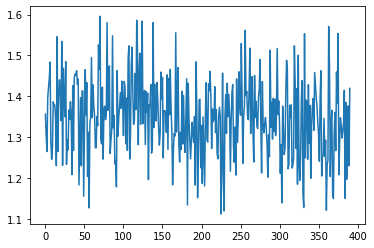

Epoch 5 done.

Average test loss: 1.3155  Accuracy: 2630/ 5000 (52.60%)


Average train loss: 1.3025  Accuracy:26144/50000 (52.29%)

[    0/50000 (  0%)]  Loss: 1.2876
[12800/50000 ( 26%)]  Loss: 1.2666
[25600/50000 ( 51%)]  Loss: 1.2830
[38400/50000 ( 77%)]  Loss: 1.2848


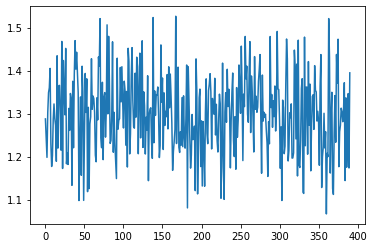

Epoch 6 done.

Average test loss: 1.2898  Accuracy: 2672/ 5000 (53.44%)


Average train loss: 1.2699  Accuracy:26699/50000 (53.40%)

[    0/50000 (  0%)]  Loss: 1.2478
[12800/50000 ( 26%)]  Loss: 1.2330
[25600/50000 ( 51%)]  Loss: 1.2341
[38400/50000 ( 77%)]  Loss: 1.2644


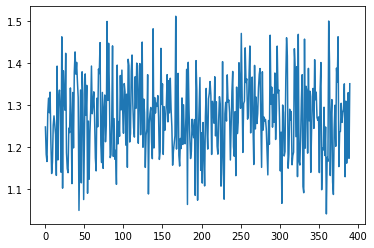

Epoch 7 done.

Average test loss: 1.2735  Accuracy: 2702/ 5000 (54.04%)


Average train loss: 1.2522  Accuracy:27004/50000 (54.01%)

[    0/50000 (  0%)]  Loss: 1.2201
[12800/50000 ( 26%)]  Loss: 1.2234
[25600/50000 ( 51%)]  Loss: 1.2337
[38400/50000 ( 77%)]  Loss: 1.2384


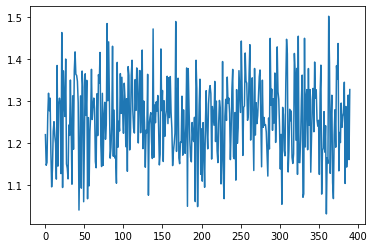

Epoch 8 done.

Average test loss: 1.2576  Accuracy: 2748/ 5000 (54.96%)


Average train loss: 1.2345  Accuracy:27368/50000 (54.74%)

[    0/50000 (  0%)]  Loss: 1.2214
[12800/50000 ( 26%)]  Loss: 1.2121
[25600/50000 ( 51%)]  Loss: 1.1955
[38400/50000 ( 77%)]  Loss: 1.2264


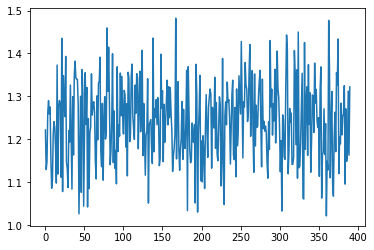

Epoch 9 done.

Average test loss: 1.2519  Accuracy: 2753/ 5000 (55.06%)


Average train loss: 1.2255  Accuracy:27504/50000 (55.01%)

Best So Far:
{'valid_acc': tensor(63.0400, device='cuda:0'), 'train_acc': tensor(68.6900, device='cuda:0'), 'lr': 0.0035287969387649185, 'L': 8, 'N': 128, 'D': 512, 'optim': <class 'torch.optim.adam.Adam'>}
[    0/50000 (  0%)]  Loss: 3.2710
[12800/50000 ( 26%)]  Loss: 1.7541
[25600/50000 ( 51%)]  Loss: 1.7694
[38400/50000 ( 77%)]  Loss: 1.5981


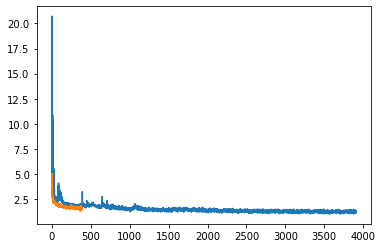

Epoch 0 done.

Average test loss: 1.5996  Accuracy: 2120/ 5000 (42.40%)


Average train loss: 1.5898  Accuracy:21043/50000 (42.09%)

[    0/50000 (  0%)]  Loss: 1.6236
[12800/50000 ( 26%)]  Loss: 1.4066
[25600/50000 ( 51%)]  Loss: 1.5091
[38400/50000 ( 77%)]  Loss: 1.3979


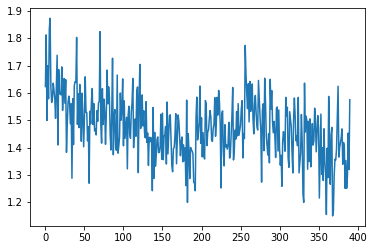

Epoch 1 done.

Average test loss: 1.4176  Accuracy: 2467/ 5000 (49.34%)


Average train loss: 1.4097  Accuracy:24746/50000 (49.49%)

[    0/50000 (  0%)]  Loss: 1.3605
[12800/50000 ( 26%)]  Loss: 1.2360
[25600/50000 ( 51%)]  Loss: 1.1971
[38400/50000 ( 77%)]  Loss: 1.2431


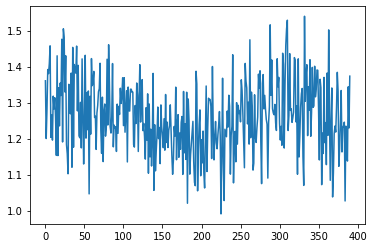

Epoch 2 done.

Average test loss: 1.2396  Accuracy: 2787/ 5000 (55.74%)


Average train loss: 1.1944  Accuracy:28450/50000 (56.90%)

[    0/50000 (  0%)]  Loss: 1.0801
[12800/50000 ( 26%)]  Loss: 1.1233
[25600/50000 ( 51%)]  Loss: 1.1398
[38400/50000 ( 77%)]  Loss: 1.0258


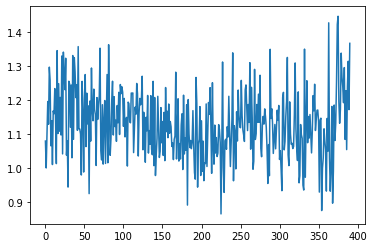

Epoch 3 done.

Average test loss: 1.1978  Accuracy: 2858/ 5000 (57.16%)


Average train loss: 1.1424  Accuracy:29699/50000 (59.40%)

[    0/50000 (  0%)]  Loss: 1.0480
[12800/50000 ( 26%)]  Loss: 1.0605
[25600/50000 ( 51%)]  Loss: 1.1169
[38400/50000 ( 77%)]  Loss: 0.9673


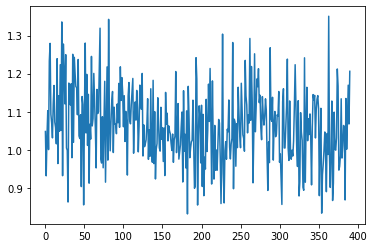

Epoch 4 done.

Average test loss: 1.0951  Accuracy: 3050/ 5000 (61.00%)


Average train loss: 0.9954  Accuracy:32067/50000 (64.13%)

[    0/50000 (  0%)]  Loss: 0.8657
[12800/50000 ( 26%)]  Loss: 0.9794
[25600/50000 ( 51%)]  Loss: 1.0371
[38400/50000 ( 77%)]  Loss: 0.8725


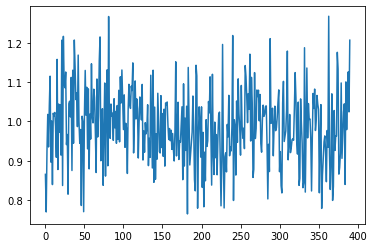

Epoch 5 done.

Average test loss: 1.0737  Accuracy: 3115/ 5000 (62.30%)


Average train loss: 0.9472  Accuracy:32967/50000 (65.93%)

[    0/50000 (  0%)]  Loss: 0.7861
[12800/50000 ( 26%)]  Loss: 0.9232
[25600/50000 ( 51%)]  Loss: 1.0058
[38400/50000 ( 77%)]  Loss: 0.8295


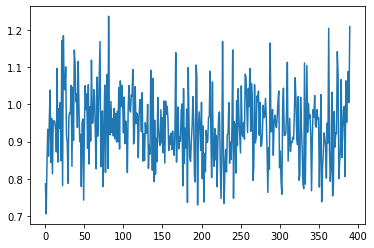

Epoch 6 done.

Average test loss: 1.0692  Accuracy: 3109/ 5000 (62.18%)


Average train loss: 0.9171  Accuracy:33434/50000 (66.87%)

[    0/50000 (  0%)]  Loss: 0.7536
[12800/50000 ( 26%)]  Loss: 0.8861
[25600/50000 ( 51%)]  Loss: 0.9806
[38400/50000 ( 77%)]  Loss: 0.8054


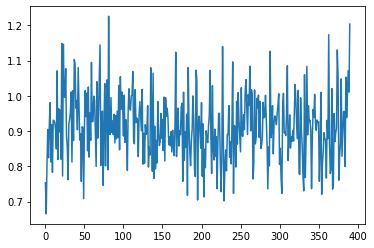

Epoch 7 done.

Average test loss: 1.0638  Accuracy: 3127/ 5000 (62.54%)


Average train loss: 0.8987  Accuracy:33787/50000 (67.57%)

[    0/50000 (  0%)]  Loss: 0.7188
[12800/50000 ( 26%)]  Loss: 0.8788
[25600/50000 ( 51%)]  Loss: 0.9734
[38400/50000 ( 77%)]  Loss: 0.8009


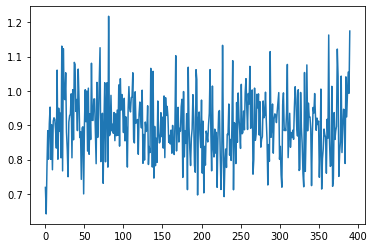

Epoch 8 done.

Average test loss: 1.0634  Accuracy: 3119/ 5000 (62.38%)


Average train loss: 0.8888  Accuracy:33999/50000 (68.00%)

[    0/50000 (  0%)]  Loss: 0.7169
[12800/50000 ( 26%)]  Loss: 0.8681
[25600/50000 ( 51%)]  Loss: 0.9656
[38400/50000 ( 77%)]  Loss: 0.7850


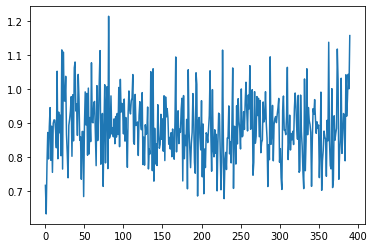

Epoch 9 done.

Average test loss: 1.0617  Accuracy: 3132/ 5000 (62.64%)


Average train loss: 0.8788  Accuracy:34160/50000 (68.32%)

Best So Far:
{'valid_acc': tensor(63.0400, device='cuda:0'), 'train_acc': tensor(68.6900, device='cuda:0'), 'lr': 0.0035287969387649185, 'L': 8, 'N': 128, 'D': 512, 'optim': <class 'torch.optim.adam.Adam'>}
[    0/50000 (  0%)]  Loss: 3.2730
[12800/50000 ( 26%)]  Loss: 1.9033
[25600/50000 ( 51%)]  Loss: 1.8233
[38400/50000 ( 77%)]  Loss: 1.8609


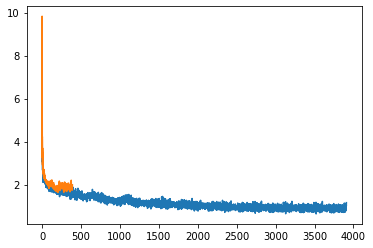

Epoch 0 done.

Average test loss: 1.7960  Accuracy: 1641/ 5000 (32.82%)


Average train loss: 1.8185  Accuracy:16281/50000 (32.56%)

[    0/50000 (  0%)]  Loss: 1.8353
[12800/50000 ( 26%)]  Loss: 1.4376
[25600/50000 ( 51%)]  Loss: 1.8232
[38400/50000 ( 77%)]  Loss: 1.6033


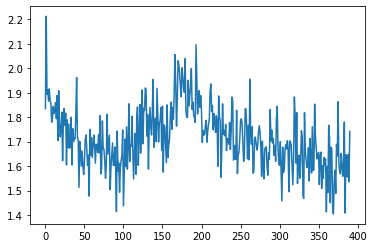

Epoch 1 done.

Average test loss: 1.5697  Accuracy: 2115/ 5000 (42.30%)


Average train loss: 1.5840  Accuracy:20620/50000 (41.24%)

[    0/50000 (  0%)]  Loss: 1.6306
[12800/50000 ( 26%)]  Loss: 1.4734
[25600/50000 ( 51%)]  Loss: 1.6902
[38400/50000 ( 77%)]  Loss: 1.5837


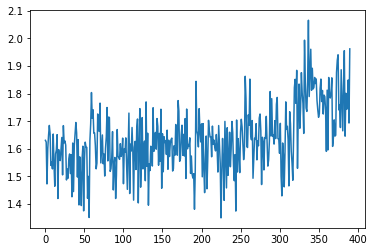

Epoch 2 done.

Average test loss: 1.8035  Accuracy: 1704/ 5000 (34.08%)


Average train loss: 1.7996  Accuracy:17356/50000 (34.71%)

[    0/50000 (  0%)]  Loss: 1.7254
[12800/50000 ( 26%)]  Loss: 1.5452
[25600/50000 ( 51%)]  Loss: 1.5717
[38400/50000 ( 77%)]  Loss: 1.6573


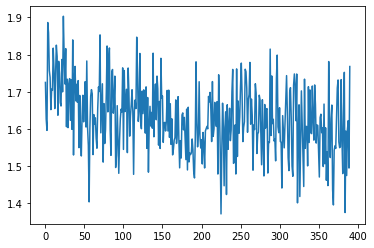

Epoch 3 done.

Average test loss: 1.5759  Accuracy: 2097/ 5000 (41.94%)


Average train loss: 1.5776  Accuracy:21003/50000 (42.01%)

[    0/50000 (  0%)]  Loss: 1.5415
[12800/50000 ( 26%)]  Loss: 1.5039
[25600/50000 ( 51%)]  Loss: 1.5530
[38400/50000 ( 77%)]  Loss: 1.5713


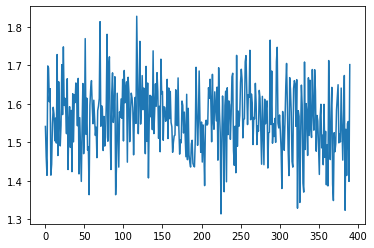

Epoch 4 done.

Average test loss: 1.5253  Accuracy: 2230/ 5000 (44.60%)


Average train loss: 1.5265  Accuracy:21952/50000 (43.90%)

[    0/50000 (  0%)]  Loss: 1.4499
[12800/50000 ( 26%)]  Loss: 1.4504
[25600/50000 ( 51%)]  Loss: 1.5124
[38400/50000 ( 77%)]  Loss: 1.5361


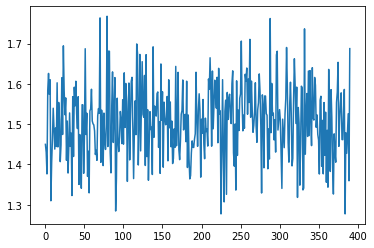

Epoch 5 done.

Average test loss: 1.4909  Accuracy: 2286/ 5000 (45.72%)


Average train loss: 1.4830  Accuracy:22761/50000 (45.52%)

[    0/50000 (  0%)]  Loss: 1.4298
[12800/50000 ( 26%)]  Loss: 1.3689
[25600/50000 ( 51%)]  Loss: 1.4777
[38400/50000 ( 77%)]  Loss: 1.4958


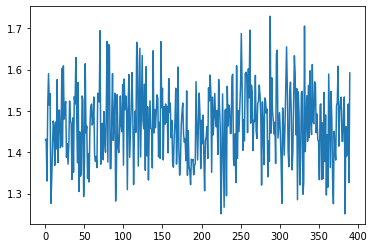

Epoch 6 done.

Average test loss: 1.4475  Accuracy: 2377/ 5000 (47.54%)


Average train loss: 1.4444  Accuracy:23570/50000 (47.14%)

[    0/50000 (  0%)]  Loss: 1.3572
[12800/50000 ( 26%)]  Loss: 1.3457
[25600/50000 ( 51%)]  Loss: 1.4496
[38400/50000 ( 77%)]  Loss: 1.4204


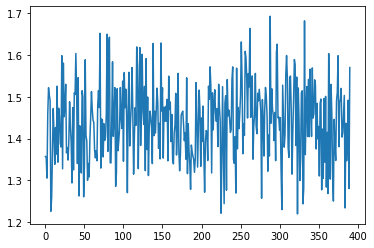

Epoch 7 done.

Average test loss: 1.4253  Accuracy: 2413/ 5000 (48.26%)


Average train loss: 1.4208  Accuracy:23920/50000 (47.84%)

[    0/50000 (  0%)]  Loss: 1.3257
[12800/50000 ( 26%)]  Loss: 1.3177
[25600/50000 ( 51%)]  Loss: 1.4378
[38400/50000 ( 77%)]  Loss: 1.3999


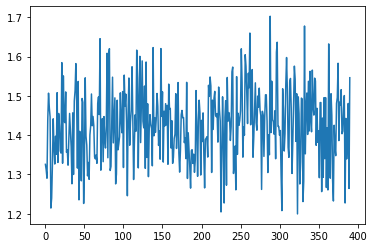

Epoch 8 done.

Average test loss: 1.4202  Accuracy: 2403/ 5000 (48.06%)


Average train loss: 1.4141  Accuracy:24064/50000 (48.13%)

[    0/50000 (  0%)]  Loss: 1.3187
[12800/50000 ( 26%)]  Loss: 1.2932
[25600/50000 ( 51%)]  Loss: 1.4405
[38400/50000 ( 77%)]  Loss: 1.3816


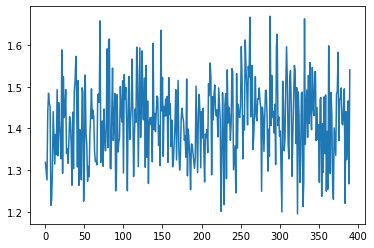

Epoch 9 done.

Average test loss: 1.4101  Accuracy: 2427/ 5000 (48.54%)


Average train loss: 1.4030  Accuracy:24301/50000 (48.60%)

Best So Far:
{'valid_acc': tensor(63.0400, device='cuda:0'), 'train_acc': tensor(68.6900, device='cuda:0'), 'lr': 0.0035287969387649185, 'L': 8, 'N': 128, 'D': 512, 'optim': <class 'torch.optim.adam.Adam'>}
[    0/50000 (  0%)]  Loss: 2.9137
[12800/50000 ( 26%)]  Loss: 2.0072
[25600/50000 ( 51%)]  Loss: 1.8178
[38400/50000 ( 77%)]  Loss: 1.7185


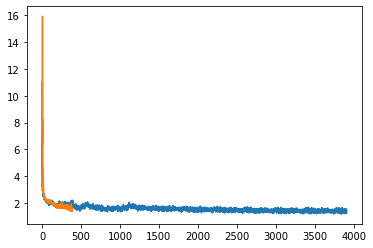

Epoch 0 done.

Average test loss: 1.5901  Accuracy: 2192/ 5000 (43.84%)


Average train loss: 1.6053  Accuracy:20925/50000 (41.85%)

[    0/50000 (  0%)]  Loss: 1.6328
[12800/50000 ( 26%)]  Loss: 1.5185
[25600/50000 ( 51%)]  Loss: 1.6992
[38400/50000 ( 77%)]  Loss: 1.5750


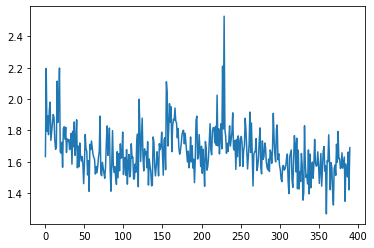

Epoch 1 done.

Average test loss: 1.6080  Accuracy: 2171/ 5000 (43.42%)


Average train loss: 1.6190  Accuracy:20715/50000 (41.43%)

[    0/50000 (  0%)]  Loss: 1.6319
[12800/50000 ( 26%)]  Loss: 1.2959
[25600/50000 ( 51%)]  Loss: 1.4824
[38400/50000 ( 77%)]  Loss: 1.5069


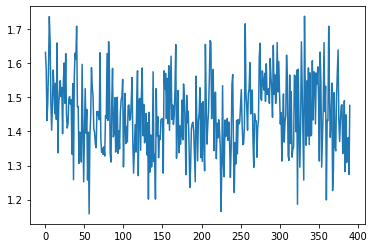

Epoch 2 done.

Average test loss: 1.4660  Accuracy: 2373/ 5000 (47.46%)


Average train loss: 1.4426  Accuracy:23740/50000 (47.48%)

[    0/50000 (  0%)]  Loss: 1.2392
[12800/50000 ( 26%)]  Loss: 1.2973
[25600/50000 ( 51%)]  Loss: 1.2744
[38400/50000 ( 77%)]  Loss: 1.2267


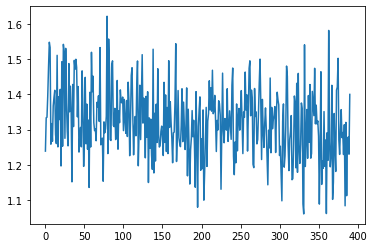

Epoch 3 done.

Average test loss: 1.2830  Accuracy: 2717/ 5000 (54.34%)


Average train loss: 1.2576  Accuracy:27226/50000 (54.45%)

[    0/50000 (  0%)]  Loss: 1.1703
[12800/50000 ( 26%)]  Loss: 1.2152
[25600/50000 ( 51%)]  Loss: 1.1706
[38400/50000 ( 77%)]  Loss: 1.1333


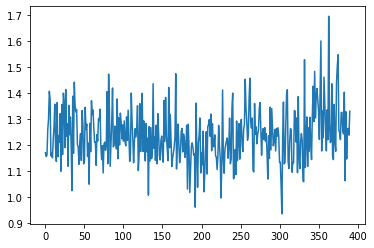

Epoch 4 done.

Average test loss: 1.2587  Accuracy: 2731/ 5000 (54.62%)


Average train loss: 1.2307  Accuracy:27751/50000 (55.50%)

[    0/50000 (  0%)]  Loss: 1.1462
[12800/50000 ( 26%)]  Loss: 1.1681
[25600/50000 ( 51%)]  Loss: 1.1450
[38400/50000 ( 77%)]  Loss: 1.0514


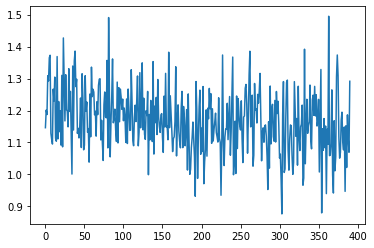

Epoch 5 done.

Average test loss: 1.1480  Accuracy: 2950/ 5000 (59.00%)


Average train loss: 1.1046  Accuracy:30187/50000 (60.37%)

[    0/50000 (  0%)]  Loss: 1.0790
[12800/50000 ( 26%)]  Loss: 1.1161
[25600/50000 ( 51%)]  Loss: 1.0660
[38400/50000 ( 77%)]  Loss: 0.9888


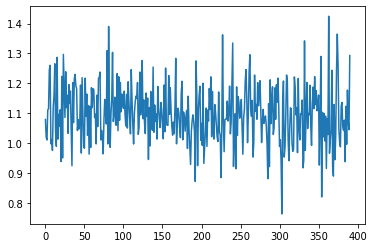

Epoch 6 done.

Average test loss: 1.1181  Accuracy: 3003/ 5000 (60.06%)


Average train loss: 1.0625  Accuracy:30977/50000 (61.95%)

[    0/50000 (  0%)]  Loss: 1.0246
[12800/50000 ( 26%)]  Loss: 1.0975
[25600/50000 ( 51%)]  Loss: 1.0348
[38400/50000 ( 77%)]  Loss: 0.9530


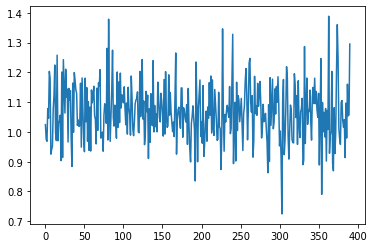

Epoch 7 done.

Average test loss: 1.1083  Accuracy: 3037/ 5000 (60.74%)


Average train loss: 1.0441  Accuracy:31290/50000 (62.58%)

[    0/50000 (  0%)]  Loss: 0.9852
[12800/50000 ( 26%)]  Loss: 1.0736
[25600/50000 ( 51%)]  Loss: 1.0279
[38400/50000 ( 77%)]  Loss: 0.9358


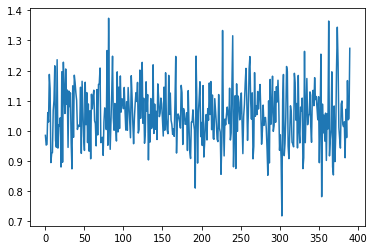

Epoch 8 done.

Average test loss: 1.0980  Accuracy: 3072/ 5000 (61.44%)


Average train loss: 1.0317  Accuracy:31527/50000 (63.05%)

[    0/50000 (  0%)]  Loss: 0.9819
[12800/50000 ( 26%)]  Loss: 1.0758
[25600/50000 ( 51%)]  Loss: 1.0025
[38400/50000 ( 77%)]  Loss: 0.9176


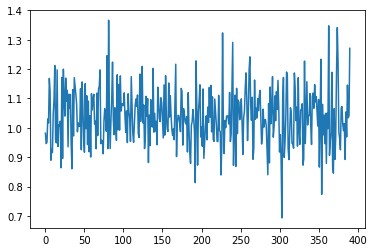

Epoch 9 done.

Average test loss: 1.0941  Accuracy: 3089/ 5000 (61.78%)


Average train loss: 1.0227  Accuracy:31717/50000 (63.43%)

Best So Far:
{'valid_acc': tensor(63.0400, device='cuda:0'), 'train_acc': tensor(68.6900, device='cuda:0'), 'lr': 0.0035287969387649185, 'L': 8, 'N': 128, 'D': 512, 'optim': <class 'torch.optim.adam.Adam'>}
[    0/50000 (  0%)]  Loss: 3.1573
[12800/50000 ( 26%)]  Loss: 2.0803
[25600/50000 ( 51%)]  Loss: 1.9719
[38400/50000 ( 77%)]  Loss: 2.0961


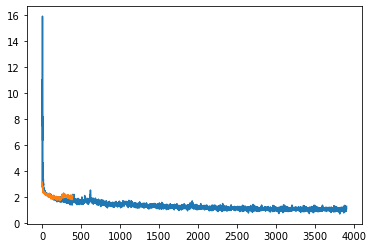

Epoch 0 done.

Average test loss: 1.9203  Accuracy: 1506/ 5000 (30.12%)


Average train loss: 1.9305  Accuracy:14271/50000 (28.54%)

[    0/50000 (  0%)]  Loss: 2.0133
[12800/50000 ( 26%)]  Loss: 1.5796
[25600/50000 ( 51%)]  Loss: 1.7106
[38400/50000 ( 77%)]  Loss: 1.7282


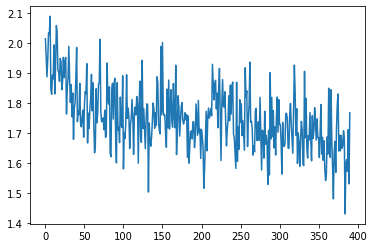

Epoch 1 done.

Average test loss: 1.6245  Accuracy: 2028/ 5000 (40.56%)


Average train loss: 1.6393  Accuracy:19986/50000 (39.97%)

[    0/50000 (  0%)]  Loss: 1.5737
[12800/50000 ( 26%)]  Loss: 1.4208
[25600/50000 ( 51%)]  Loss: 1.4593
[38400/50000 ( 77%)]  Loss: 1.4073


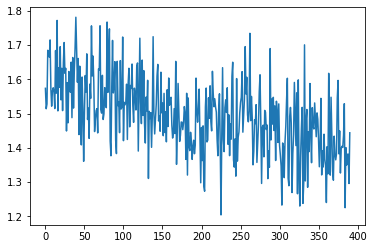

Epoch 2 done.

Average test loss: 1.3736  Accuracy: 2492/ 5000 (49.84%)


Average train loss: 1.3611  Accuracy:25101/50000 (50.20%)

[    0/50000 (  0%)]  Loss: 1.2595
[12800/50000 ( 26%)]  Loss: 1.2368
[25600/50000 ( 51%)]  Loss: 1.2748
[38400/50000 ( 77%)]  Loss: 1.2167


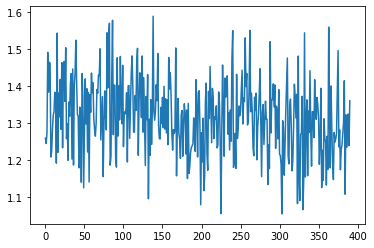

Epoch 3 done.

Average test loss: 1.2978  Accuracy: 2647/ 5000 (52.94%)


Average train loss: 1.2505  Accuracy:27260/50000 (54.52%)

[    0/50000 (  0%)]  Loss: 1.1390
[12800/50000 ( 26%)]  Loss: 1.1613
[25600/50000 ( 51%)]  Loss: 1.2013
[38400/50000 ( 77%)]  Loss: 1.1287


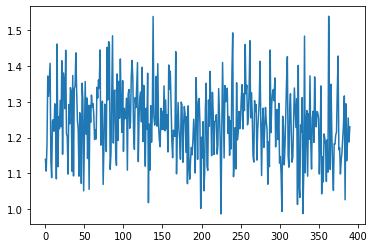

Epoch 4 done.

Average test loss: 1.2612  Accuracy: 2737/ 5000 (54.74%)


Average train loss: 1.1827  Accuracy:28546/50000 (57.09%)

[    0/50000 (  0%)]  Loss: 1.0635
[12800/50000 ( 26%)]  Loss: 1.0503
[25600/50000 ( 51%)]  Loss: 1.1282
[38400/50000 ( 77%)]  Loss: 1.0562


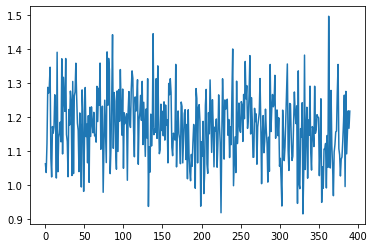

Epoch 5 done.

Average test loss: 1.2433  Accuracy: 2808/ 5000 (56.16%)


Average train loss: 1.1377  Accuracy:29409/50000 (58.82%)

[    0/50000 (  0%)]  Loss: 0.9911
[12800/50000 ( 26%)]  Loss: 0.9950
[25600/50000 ( 51%)]  Loss: 1.0947
[38400/50000 ( 77%)]  Loss: 1.0154


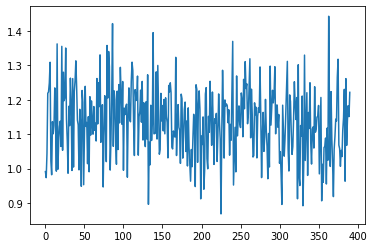

Epoch 6 done.

Average test loss: 1.2367  Accuracy: 2801/ 5000 (56.02%)


Average train loss: 1.1151  Accuracy:29845/50000 (59.69%)

[    0/50000 (  0%)]  Loss: 0.9621
[12800/50000 ( 26%)]  Loss: 0.9627
[25600/50000 ( 51%)]  Loss: 1.0724
[38400/50000 ( 77%)]  Loss: 0.9937


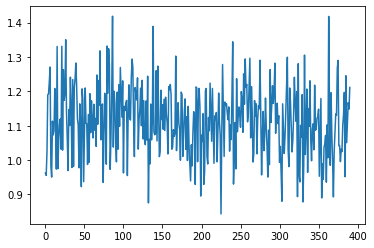

Epoch 7 done.

Average test loss: 1.2307  Accuracy: 2823/ 5000 (56.46%)


Average train loss: 1.1027  Accuracy:30086/50000 (60.17%)

[    0/50000 (  0%)]  Loss: 0.9346
[12800/50000 ( 26%)]  Loss: 0.9531
[25600/50000 ( 51%)]  Loss: 1.0611
[38400/50000 ( 77%)]  Loss: 0.9826


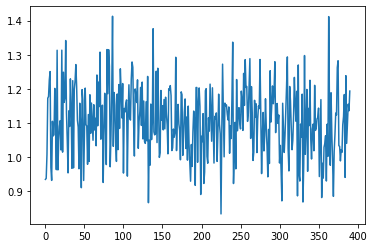

Epoch 8 done.

Average test loss: 1.2290  Accuracy: 2823/ 5000 (56.46%)


Average train loss: 1.0947  Accuracy:30236/50000 (60.47%)

[    0/50000 (  0%)]  Loss: 0.9279
[12800/50000 ( 26%)]  Loss: 0.9383
[25600/50000 ( 51%)]  Loss: 1.0504
[38400/50000 ( 77%)]  Loss: 0.9695


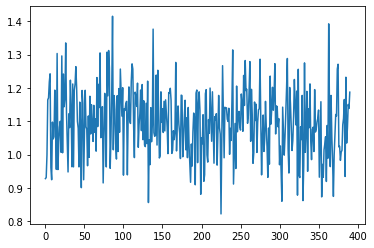

Epoch 9 done.

Average test loss: 1.2262  Accuracy: 2828/ 5000 (56.56%)


Average train loss: 1.0882  Accuracy:30342/50000 (60.68%)

Best So Far:
{'valid_acc': tensor(63.0400, device='cuda:0'), 'train_acc': tensor(68.6900, device='cuda:0'), 'lr': 0.0035287969387649185, 'L': 8, 'N': 128, 'D': 512, 'optim': <class 'torch.optim.adam.Adam'>}
[    0/50000 (  0%)]  Loss: 3.4471
[12800/50000 ( 26%)]  Loss: 2.2500
[25600/50000 ( 51%)]  Loss: 1.8921
[38400/50000 ( 77%)]  Loss: 1.6419


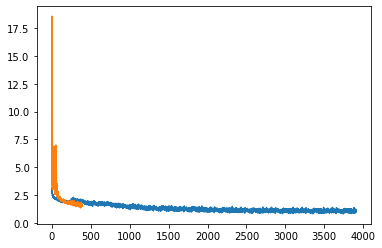

Epoch 0 done.

Average test loss: 1.5915  Accuracy: 2053/ 5000 (41.06%)


Average train loss: 1.6014  Accuracy:19978/50000 (39.96%)

[    0/50000 (  0%)]  Loss: 1.7547
[12800/50000 ( 26%)]  Loss: 1.5137
[25600/50000 ( 51%)]  Loss: 1.5201
[38400/50000 ( 77%)]  Loss: 3.0822


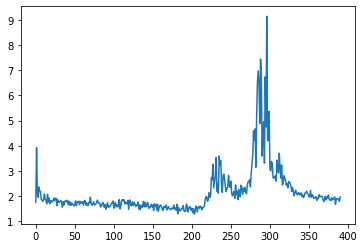

Epoch 1 done.

Average test loss: 1.8619  Accuracy: 1642/ 5000 (32.84%)


Average train loss: 1.8616  Accuracy:16314/50000 (32.63%)

[    0/50000 (  0%)]  Loss: 1.9271
[12800/50000 ( 26%)]  Loss: 1.5081
[25600/50000 ( 51%)]  Loss: 1.5028
[38400/50000 ( 77%)]  Loss: 1.4938


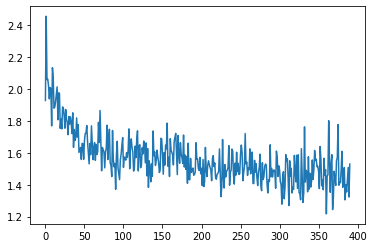

Epoch 2 done.

Average test loss: 1.4509  Accuracy: 2330/ 5000 (46.60%)


Average train loss: 1.4447  Accuracy:22906/50000 (45.81%)

[    0/50000 (  0%)]  Loss: 1.3324
[12800/50000 ( 26%)]  Loss: 1.4160
[25600/50000 ( 51%)]  Loss: 1.3508
[38400/50000 ( 77%)]  Loss: 1.3648


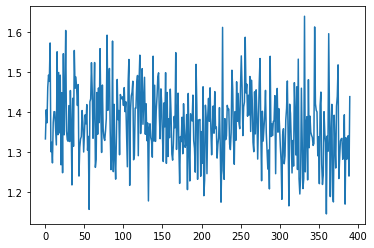

Epoch 3 done.

Average test loss: 1.3233  Accuracy: 2537/ 5000 (50.74%)


Average train loss: 1.3018  Accuracy:26084/50000 (52.17%)

[    0/50000 (  0%)]  Loss: 1.1430
[12800/50000 ( 26%)]  Loss: 1.3660
[25600/50000 ( 51%)]  Loss: 1.2403
[38400/50000 ( 77%)]  Loss: 1.2623


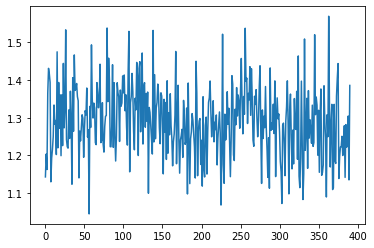

Epoch 4 done.

Average test loss: 1.2554  Accuracy: 2725/ 5000 (54.50%)


Average train loss: 1.2230  Accuracy:27735/50000 (55.47%)

[    0/50000 (  0%)]  Loss: 1.0835
[12800/50000 ( 26%)]  Loss: 1.2733
[25600/50000 ( 51%)]  Loss: 1.1585
[38400/50000 ( 77%)]  Loss: 1.1372


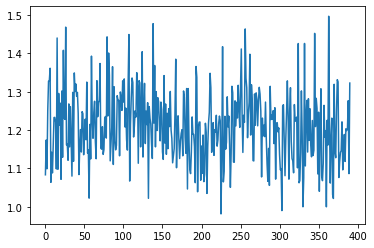

Epoch 5 done.

Average test loss: 1.2063  Accuracy: 2832/ 5000 (56.64%)


Average train loss: 1.1584  Accuracy:28977/50000 (57.95%)

[    0/50000 (  0%)]  Loss: 1.0174
[12800/50000 ( 26%)]  Loss: 1.2418
[25600/50000 ( 51%)]  Loss: 1.1173
[38400/50000 ( 77%)]  Loss: 1.0584


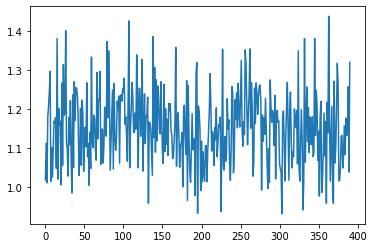

Epoch 6 done.

Average test loss: 1.1705  Accuracy: 2907/ 5000 (58.14%)


Average train loss: 1.1146  Accuracy:29768/50000 (59.54%)

[    0/50000 (  0%)]  Loss: 0.9814
[12800/50000 ( 26%)]  Loss: 1.1609
[25600/50000 ( 51%)]  Loss: 1.1015
[38400/50000 ( 77%)]  Loss: 1.0081


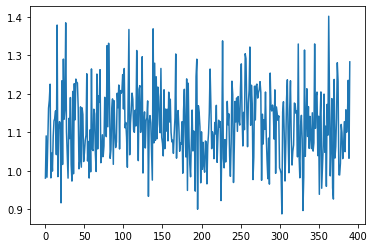

Epoch 7 done.

Average test loss: 1.1607  Accuracy: 2931/ 5000 (58.62%)


Average train loss: 1.0964  Accuracy:30104/50000 (60.21%)

[    0/50000 (  0%)]  Loss: 0.9541
[12800/50000 ( 26%)]  Loss: 1.1565
[25600/50000 ( 51%)]  Loss: 1.0889
[38400/50000 ( 77%)]  Loss: 0.9969


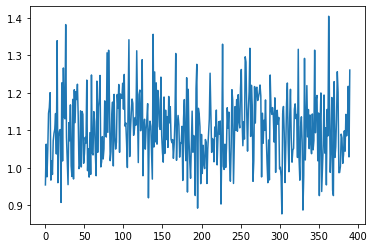

Epoch 8 done.

Average test loss: 1.1526  Accuracy: 2951/ 5000 (59.02%)


Average train loss: 1.0836  Accuracy:30329/50000 (60.66%)

[    0/50000 (  0%)]  Loss: 0.9433
[12800/50000 ( 26%)]  Loss: 1.1428
[25600/50000 ( 51%)]  Loss: 1.0785
[38400/50000 ( 77%)]  Loss: 0.9806


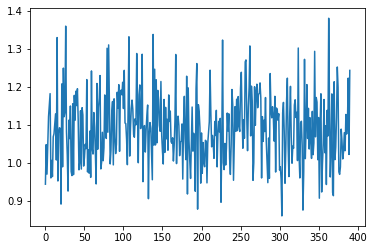

Epoch 9 done.

Average test loss: 1.1458  Accuracy: 2965/ 5000 (59.30%)


Average train loss: 1.0756  Accuracy:30547/50000 (61.09%)

Best So Far:
{'valid_acc': tensor(63.0400, device='cuda:0'), 'train_acc': tensor(68.6900, device='cuda:0'), 'lr': 0.0035287969387649185, 'L': 8, 'N': 128, 'D': 512, 'optim': <class 'torch.optim.adam.Adam'>}
[    0/50000 (  0%)]  Loss: 3.0225
[12800/50000 ( 26%)]  Loss: 1.9229
[25600/50000 ( 51%)]  Loss: 1.8211
[38400/50000 ( 77%)]  Loss: 1.6641


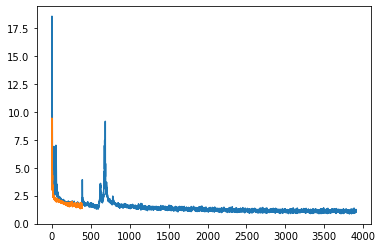

Epoch 0 done.

Average test loss: 1.5263  Accuracy: 2257/ 5000 (45.14%)


Average train loss: 1.5199  Accuracy:22310/50000 (44.62%)

[    0/50000 (  0%)]  Loss: 1.5731
[12800/50000 ( 26%)]  Loss: 1.4059
[25600/50000 ( 51%)]  Loss: 1.4559
[38400/50000 ( 77%)]  Loss: 1.3594


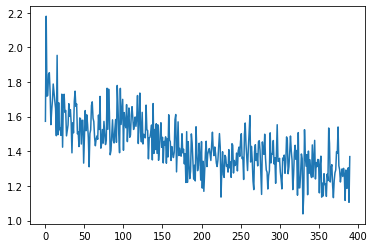

Epoch 1 done.

Average test loss: 1.2475  Accuracy: 2815/ 5000 (56.30%)


Average train loss: 1.2137  Accuracy:28333/50000 (56.67%)

[    0/50000 (  0%)]  Loss: 1.0874
[12800/50000 ( 26%)]  Loss: 1.0219
[25600/50000 ( 51%)]  Loss: 1.2878
[38400/50000 ( 77%)]  Loss: 1.2839


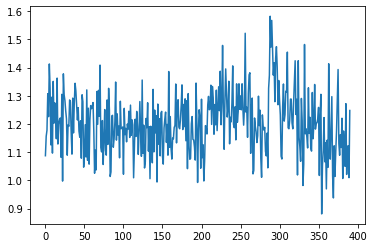

Epoch 2 done.

Average test loss: 1.2002  Accuracy: 2874/ 5000 (57.48%)


Average train loss: 1.1547  Accuracy:29312/50000 (58.62%)

[    0/50000 (  0%)]  Loss: 0.9661
[12800/50000 ( 26%)]  Loss: 0.9690
[25600/50000 ( 51%)]  Loss: 1.1655
[38400/50000 ( 77%)]  Loss: 0.9809


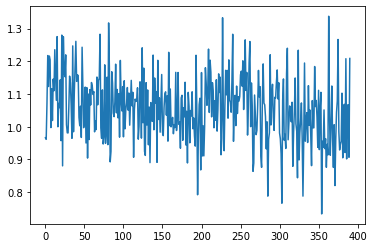

Epoch 3 done.

Average test loss: 1.0981  Accuracy: 3076/ 5000 (61.52%)


Average train loss: 1.0166  Accuracy:32090/50000 (64.18%)

[    0/50000 (  0%)]  Loss: 0.8339
[12800/50000 ( 26%)]  Loss: 0.8838
[25600/50000 ( 51%)]  Loss: 1.1015
[38400/50000 ( 77%)]  Loss: 0.9163


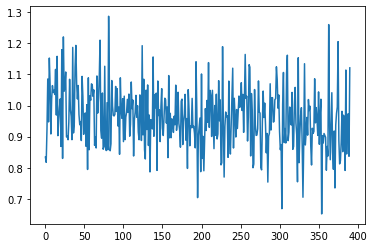

Epoch 4 done.

Average test loss: 1.0222  Accuracy: 3199/ 5000 (63.98%)


Average train loss: 0.8949  Accuracy:34148/50000 (68.30%)

[    0/50000 (  0%)]  Loss: 0.6973
[12800/50000 ( 26%)]  Loss: 0.7946
[25600/50000 ( 51%)]  Loss: 1.0615
[38400/50000 ( 77%)]  Loss: 0.8302


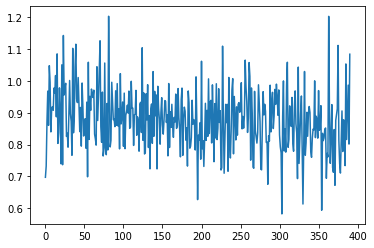

Epoch 5 done.

Average test loss: 0.9968  Accuracy: 3273/ 5000 (65.46%)


Average train loss: 0.8291  Accuracy:35273/50000 (70.55%)

[    0/50000 (  0%)]  Loss: 0.5983
[12800/50000 ( 26%)]  Loss: 0.7564
[25600/50000 ( 51%)]  Loss: 0.9818
[38400/50000 ( 77%)]  Loss: 0.7699


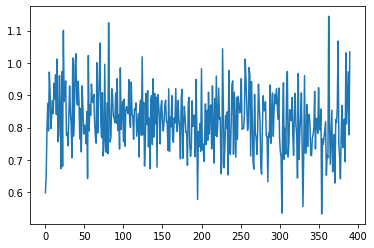

Epoch 6 done.

Average test loss: 0.9931  Accuracy: 3276/ 5000 (65.52%)


Average train loss: 0.7962  Accuracy:35920/50000 (71.84%)

[    0/50000 (  0%)]  Loss: 0.5492
[12800/50000 ( 26%)]  Loss: 0.7444
[25600/50000 ( 51%)]  Loss: 0.9469
[38400/50000 ( 77%)]  Loss: 0.7356


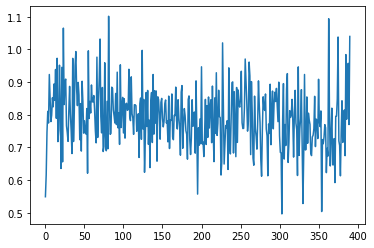

Epoch 7 done.

Average test loss: 0.9899  Accuracy: 3294/ 5000 (65.88%)


Average train loss: 0.7754  Accuracy:36293/50000 (72.59%)

[    0/50000 (  0%)]  Loss: 0.5089
[12800/50000 ( 26%)]  Loss: 0.7211
[25600/50000 ( 51%)]  Loss: 0.9311
[38400/50000 ( 77%)]  Loss: 0.7310


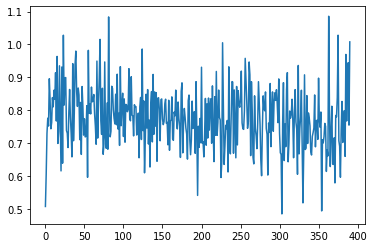

Epoch 8 done.

Average test loss: 0.9912  Accuracy: 3309/ 5000 (66.18%)


Average train loss: 0.7625  Accuracy:36477/50000 (72.95%)

[    0/50000 (  0%)]  Loss: 0.5011
[12800/50000 ( 26%)]  Loss: 0.7125
[25600/50000 ( 51%)]  Loss: 0.9102
[38400/50000 ( 77%)]  Loss: 0.7175


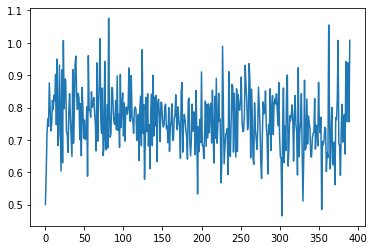

Epoch 9 done.

Average test loss: 0.9895  Accuracy: 3315/ 5000 (66.30%)


Average train loss: 0.7517  Accuracy:36706/50000 (73.41%)

Best So Far:
{'valid_acc': tensor(66.3000, device='cuda:0'), 'train_acc': tensor(73.4120, device='cuda:0'), 'lr': 0.0032539624980194295, 'L': 8, 'N': 128, 'D': 512, 'optim': <class 'torch.optim.adam.Adam'>}
{'valid_acc': tensor(66.3000, device='cuda:0'), 'train_acc': tensor(73.4120, device='cuda:0'), 'lr': 0.0032539624980194295, 'L': 8, 'N': 128, 'D': 512, 'optim': <class 'torch.optim.adam.Adam'>}


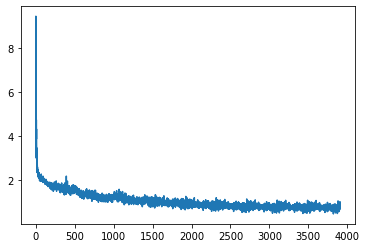

In [20]:
best = param_search()
print(best)
store_params(best, "best_of_all_test")

In [ ]:
"""
{
    'valid_acc': tensor(65.9000, device='cuda:0'), 
    'train_acc': tensor(68.5020, device='cuda:0'), 
    'lr': 0.004095672975699754, 
    'L': 8, 
    'N': 128, 
    'D': 512, 
    'optim': <class 'torch.optim.adam.Adam'>
}
"""

In [ ]:
from torchvision import models

resnet = models.resnet18(pretrained=False)
print(resnet)



[    0/50000 (  0%)]  Loss: 0.6402
[12800/50000 ( 26%)]  Loss: 0.5320
[25600/50000 ( 51%)]  Loss: 0.6355
[38400/50000 ( 77%)]  Loss: 0.5975


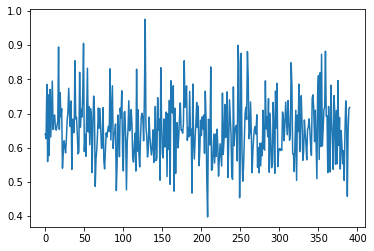

Epoch 0 done.

Average test loss: 0.8613  Accuracy: 7043/10000 (70.43%)


Average train loss: 0.6270  Accuracy:39062/50000 (78.12%)

[    0/50000 (  0%)]  Loss: 0.6773
[12800/50000 ( 26%)]  Loss: 0.6739
[25600/50000 ( 51%)]  Loss: 0.5459
[38400/50000 ( 77%)]  Loss: 0.5078


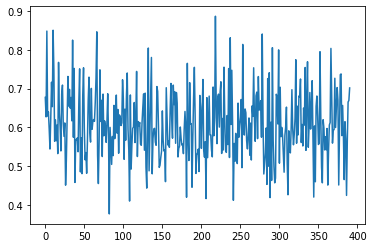

Epoch 1 done.

Average test loss: 0.8288  Accuracy: 7171/10000 (71.71%)


Average train loss: 0.5556  Accuracy:40345/50000 (80.69%)

[    0/50000 (  0%)]  Loss: 0.5206
[12800/50000 ( 26%)]  Loss: 0.6327
[25600/50000 ( 51%)]  Loss: 0.5611
[38400/50000 ( 77%)]  Loss: 0.5935


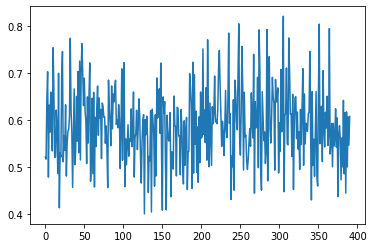

Epoch 2 done.

Average test loss: 0.8379  Accuracy: 7162/10000 (71.62%)


Average train loss: 0.5422  Accuracy:40622/50000 (81.24%)

[    0/50000 (  0%)]  Loss: 0.4720
[12800/50000 ( 26%)]  Loss: 0.5018
[25600/50000 ( 51%)]  Loss: 0.5766
[38400/50000 ( 77%)]  Loss: 0.6645


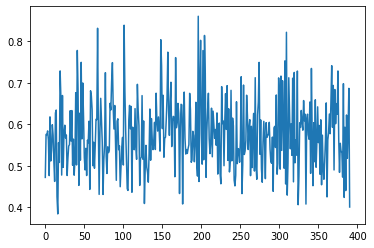

Epoch 3 done.

Average test loss: 0.8400  Accuracy: 7198/10000 (71.98%)


Average train loss: 0.5331  Accuracy:40771/50000 (81.54%)

[    0/50000 (  0%)]  Loss: 0.6040
[12800/50000 ( 26%)]  Loss: 0.5124
[25600/50000 ( 51%)]  Loss: 0.6184
[38400/50000 ( 77%)]  Loss: 0.6900


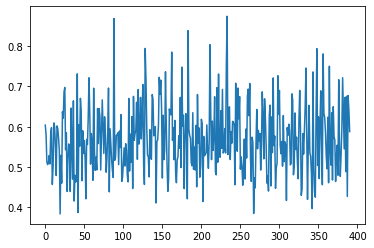

Epoch 4 done.

Average test loss: 0.8507  Accuracy: 7207/10000 (72.07%)


Average train loss: 0.5257  Accuracy:40921/50000 (81.84%)

[    0/50000 (  0%)]  Loss: 0.5195
[12800/50000 ( 26%)]  Loss: 0.5534
[25600/50000 ( 51%)]  Loss: 0.6048
[38400/50000 ( 77%)]  Loss: 0.7099


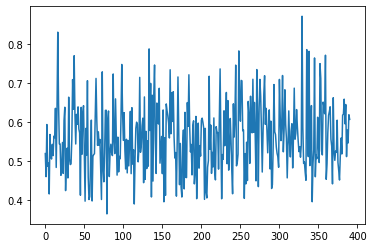

Epoch 5 done.

Average test loss: 0.8575  Accuracy: 7175/10000 (71.75%)


Average train loss: 0.5191  Accuracy:41056/50000 (82.11%)

[    0/50000 (  0%)]  Loss: 0.5631
[12800/50000 ( 26%)]  Loss: 0.4490
[25600/50000 ( 51%)]  Loss: 0.5962
[38400/50000 ( 77%)]  Loss: 0.5267


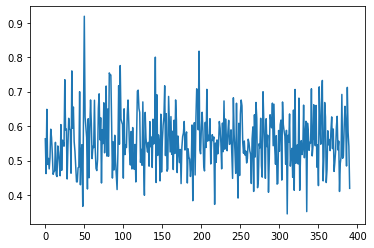

Epoch 6 done.

Average test loss: 0.8558  Accuracy: 7191/10000 (71.91%)


Average train loss: 0.5100  Accuracy:41202/50000 (82.40%)

[    0/50000 (  0%)]  Loss: 0.6144
[12800/50000 ( 26%)]  Loss: 0.6112
[25600/50000 ( 51%)]  Loss: 0.5502
[38400/50000 ( 77%)]  Loss: 0.5044


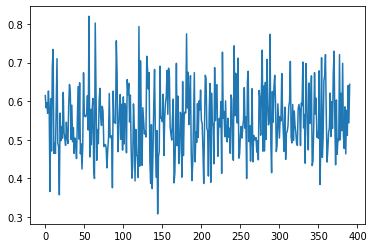

Epoch 7 done.

Average test loss: 0.8601  Accuracy: 7193/10000 (71.93%)


Average train loss: 0.4999  Accuracy:41392/50000 (82.78%)

[    0/50000 (  0%)]  Loss: 0.5622
[12800/50000 ( 26%)]  Loss: 0.5678
[25600/50000 ( 51%)]  Loss: 0.5405
[38400/50000 ( 77%)]  Loss: 0.5423


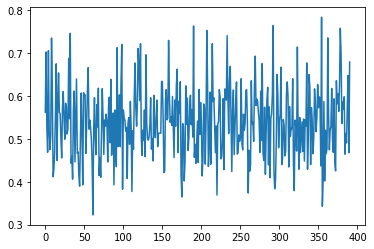

Epoch 8 done.

Average test loss: 0.8650  Accuracy: 7214/10000 (72.14%)


Average train loss: 0.4854  Accuracy:41684/50000 (83.37%)

[    0/50000 (  0%)]  Loss: 0.4238
[12800/50000 ( 26%)]  Loss: 0.4439
[25600/50000 ( 51%)]  Loss: 0.4227
[38400/50000 ( 77%)]  Loss: 0.5251


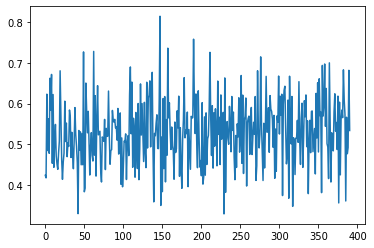

Epoch 9 done.

Average test loss: 0.8735  Accuracy: 7180/10000 (71.80%)


Average train loss: 0.4800  Accuracy:41823/50000 (83.65%)

tensor(71.8000, device='cuda:0') tensor(83.6460, device='cuda:0')


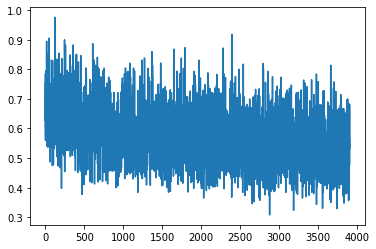

In [24]:
epochs = 10
lr = 0.001
lr_decay = 1
decay_every = 30
weight_decay = 4e-5
optim = torch.optim.Adam
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)


N = 128

train_loader = DataLoader(data_train, batch_size=N, shuffle=True)
valid_loader = DataLoader(data_valid, batch_size=N, shuffle=False)

valid_acc, train_acc, all_hist = train_attempt(
    resnet, 
    optimizer, 
    train_loader, 
    valid_loader, 
    epochs,
    lr,
    lr_decay,
    decay_every,
    weight_decay,
    optim
)

print(valid_acc, train_acc)